<a href="https://colab.research.google.com/github/gnryu/ML22-2/blob/main/PHW2/result/Clarans_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the dataset using the wget command
!wget https://game.chromato99.com/housing.csv
!pip install pyclustering
!pip install category_encodersa
!pip install category_encoders

--2022-10-03 09:25:53--  https://game.chromato99.com/housing.csv
Resolving game.chromato99.com (game.chromato99.com)... 119.64.43.218
Connecting to game.chromato99.com (game.chromato99.com)|119.64.43.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [application/octet-stream]
Saving to: ‘housing.csv.12’

housing.csv.12      100%[===================>]   1.36M  3.77MB/s    in 0.4s    

2022-10-03 09:25:54 (3.77 MB/s) - ‘housing.csv.12’ saved [1423529/1423529]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement category_encodersa (from versions: none)
ERROR: No matching distribution found for category_encodersa
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from itertools import product

In [ ]:
data = pd.read_csv('./housing.csv', sep=',')
print(data)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

In [ ]:
# replace the value of ? to NaN
data.replace("?", np.NaN, inplace = True)
print(data.isna().sum())

# drop the row which has NaN value
data.dropna(inplace = True) 

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [ ]:
X = data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
print(X)

y = data.iloc[:, 8] # target feature
print(y)


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income ocean_

In [ ]:
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def tsne(data):
    tsne_result = TSNE(n_components=2).fit_transform(data)
    return tsne_result

In [ ]:
data_copy = data.copy()

corr_matrix = data_copy.corr()
corr_matrix_n = corr_matrix['median_house_value'].sort_values(ascending = False).nlargest(6)
corr_matrix_n

median_house_value    1.000000
median_income         0.688355
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
Name: median_house_value, dtype: float64

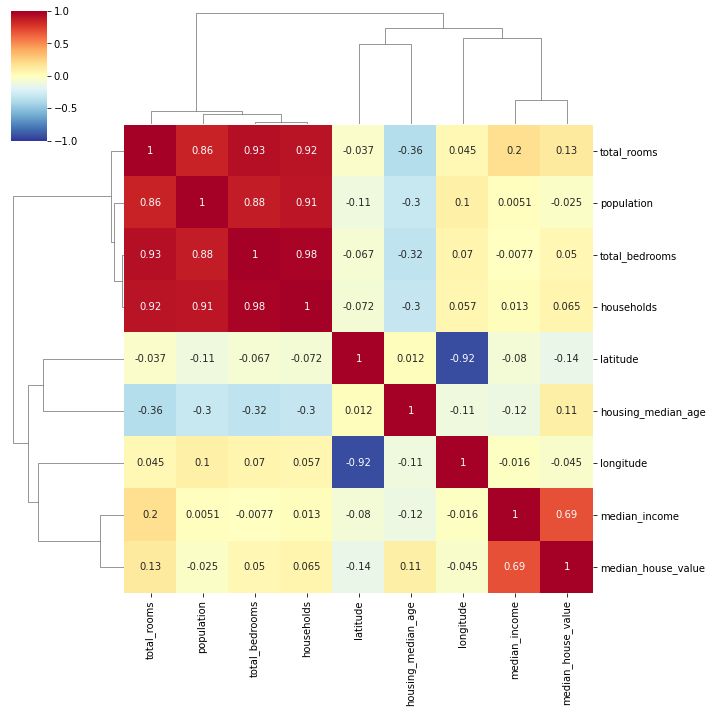

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(corr_matrix, annot = True, cmap = 'RdYlBu_r', vmin = -1, vmax = 1)

In [ ]:
from sklearn import metrics

def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    return score

In [ ]:
def combine_data_features(data, feature_combination):
  
  data = data[feature_combination]
  return data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
import category_encoders

pd.set_option('mode.chained_assignment',  None) 

def encode_data(data, house_price, encoder_type):
  if encoder_type == 'LabelEncoder':
    encoder = LabelEncoder()
    encoder.fit(data['ocean_proximity'])
    data['ocean_proximity'] = encoder.transform(data['ocean_proximity'])
  
  elif encoder_type == 'OneHotEncoder':
    data = pd.get_dummies(data, columns = ['ocean_proximity'], drop_first = True)

  elif encoder_type == 'TargetEncoder':
    encoder = TargetEncoder()
    data['ocean_proximity_encoded'] = encoder.fit_transform(data['ocean_proximity'], house_price)
    data.drop('ocean_proximity', axis = 1, inplace = True)
  
  return data

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale_data(data, scaler_type):
  if scaler_type == 'StandardScaler':
    scaler = StandardScaler()
  
  elif scaler_type == 'MinMaxScaler':
    scaler = MinMaxScaler()

  elif scaler_type == 'RobustScaler':
    scaler = RobustScaler()

  scaler.fit(data)
  data = scaler.transform(data)

  return data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall

def cluster_data(X, model, hyper_parameter_dict, n_cluster, quality_measure):
  if model == 'KMeans':
    clustering_algorithm = KMeans()
    gs = GridSearchCV(clustering_algorithm, param_grid = hyper_parameter_dict, scoring=quality_measure, refit=True).fit(X)

    m = KMeans(n_clusters = n_cluster, random_state = gs.best_params_['random_state']).fit(X)
    print("Best params : ", gs.best_params_)
    print("inertia: ", m.inertia_)


  elif model == "DBSCAN":
    clustering_algorithm = DBSCAN()
    gs = GridSearchCV(clustering_algorithm, param_grid = hyper_parameter_dict, scoring=quality_measure, refit=True).fit(X)
    print("Best params : ", gs.best_params_)
    m = DBSCAN(eps = gs.best_params_['eps'], min_samples = gs.best_params_['min_samples']).fit(X)
    
  elif model == 'EM':
    clustering_algorithm = GaussianMixture()
    gs = GridSearchCV(clustering_algorithm, param_grid = hyper_parameter_dict, scoring=quality_measure, refit=True).fit(X)
    print("Best params : ", gs.best_params_)
    m = GaussianMixture(n_components= n_cluster, random_state=gs.best_params_['random_state']).fit(X)

    gmm_labels = m.fit_predict(X)
    

  elif model == 'CLARANS':
    clarans_instance = clarans(X, n_cluster, 3, 5)
    (ticks, result) = timedcall(clarans_instance.process)
    m = clarans_instance
  return m

In [ ]:
import matplotlib.pyplot as plt
import math
def visualize(model, model_name, scaled_data, tsne_data, house_price, feature_combination):
    label = []
    if model_name == "DBSCAN": 
        label = model.labels_
    elif model_name == 'CLARANS':
        clusters = model.get_clusters()
        label = [0 for i in range(len(scaled_data))]
        c_num = 0
        for cluster in clusters:
            for l in cluster:
                label[l] = c_num
            c_num += 1
    else:
        label = model.predict(scaled_data)
    #Getting unique labels
    u_labels, l_counts = np.unique(label, return_counts=True)
    print("Count labels: ", len(u_labels))
    if len(u_labels) > 1 :
        score = metrics.silhouette_score(scaled_data, label)
        print("Silhouette score: ", score)
    index_num = 1

    num = 0
    for i in range(len(feature_combination)):
        num += i
    if num < 1:
        num = 1

    fig = plt.figure(figsize=(18, 6))
    fig.tight_layout()
    ax = fig.add_subplot(131, projection='3d')
    for i in u_labels:
        ax.scatter(tsne_data[label == i , 0] , tsne_data[label == i , 1], house_price[label == i] , label = i, s=5)
    ax.set_title('Visualize by t-SNE')
    ax.set_xlabel('tsne1')
    ax.set_ylabel('tsne2')
    
    ax = fig.add_subplot(132)
    for i in u_labels:
        ax.scatter(tsne_data[label == i , 0] , tsne_data[label == i , 1], label = i, s=5)
    ax.set_title('Visualize by t-SNE')
    ax.set_xlabel('tsne1')
    ax.set_ylabel('tsne2')

    ax = fig.add_subplot(133)
    ax.bar(u_labels, l_counts)
    ax.set_xlabel('label')
    ax.set_ylabel('count')
    plt.show()

In [ ]:
def preprocess(dataset, encoder_list, scaler_list, feature_combinations):
    preprocessed_data = [[[dataset for _ in range(len(encoder_list))] for _ in range(len(scaler_list))] for _ in range(len(feature_combinations))]
    preprocessed_tsne_data = [[[dataset for _ in range(len(encoder_list))] for _ in range(len(scaler_list))] for _ in range(len(feature_combinations))]
    feature_data = dataset.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
    house_price = dataset.iloc[:, 8] # target feature
    for i in range(len(encoder_list)):
        for j in range(len(scaler_list)):
            for k in range(len(feature_combinations)):
                combined_data = combine_data_features(feature_data, feature_combinations[k])

                if 'ocean_proximity' in feature_combinations[k]:
                    encoded_data = encode_data(combined_data, house_price, encoder_list[i])
                else:
                    encoded_data = combined_data

                scaled_data = scale_data(encoded_data, scaler_list[j])
                preprocessed_data[i][j][k] = scaled_data
                preprocessed_tsne_data[i][j][k] = tsne(scaled_data)
    return preprocessed_data, preprocessed_tsne_data

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
def AutoML(dataset, model_list, encoder_list, scaler_list, n_clusters, feature_combinations, hyper_parameter_dict, quality_measure):

  items = [model_list, encoder_list, scaler_list, n_clusters, feature_combinations]
  combinations = list(product(*items))

  for model, encoder, scaler, n_cluster, feature_combination in combinations:
    if model == 'DBSCAN' and n_cluster > 2:
      continue
    print("\n\n\n===================================================================")
    print("Model: ", model)
    print("Encoder: ", encoder)
    print("Scaler: ", scaler)
    print("Feature list: ", feature_combination)
    if model != 'DBSCAN': 
      print("n_cluster: ", n_cluster)

    # test with sample
    if model == 'CLARANS':
      sample_dataset = dataset.sample(n=400)
      feature_data = sample_dataset.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
      house_price = sample_dataset.iloc[:, 8] # target feature
      combined_data = combine_data_features(feature_data, feature_combination)
      if 'ocean_proximity' in feature_combination:
        encoded_data = encode_data(combined_data, house_price, encoder)
      else:
        encoded_data = combined_data
      scaled_data = scale_data(encoded_data, scaler)
    else:
      feature_data = dataset.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
      house_price = dataset.iloc[:, 8] # target feature
      scaled_data = preprocessed_data[encoder_list.index(encoder)][scaler_list.index(scaler)][feature_combinations.index(feature_combination)]
    
    m = cluster_data(scaled_data, model, hyper_parameter_dict[model], n_cluster, quality_measure)

    if model == 'CLARANS':
      tsne_data = tsne(scaled_data)
    else:
      tsne_data = preprocessed_tsne_data[encoder_list.index(encoder)][scaler_list.index(scaler)][feature_combinations.index(feature_combination)]

    visualize(m, model, scaled_data, tsne_data, house_price, feature_combination)




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.4030349997963569


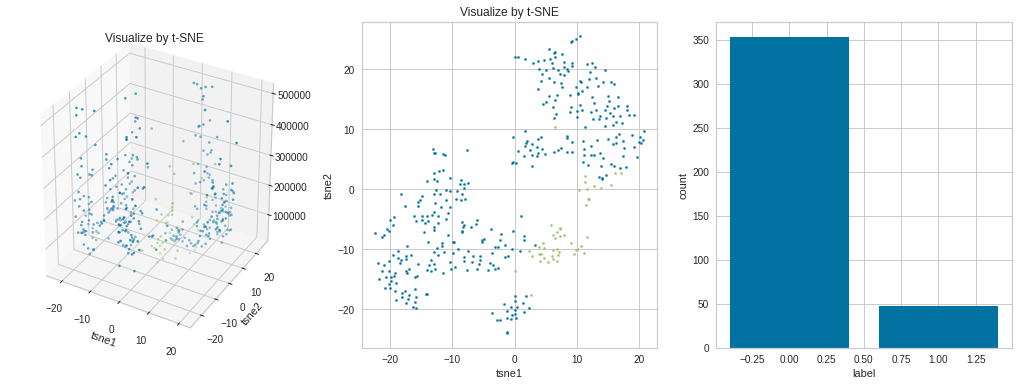




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.5345211755029105


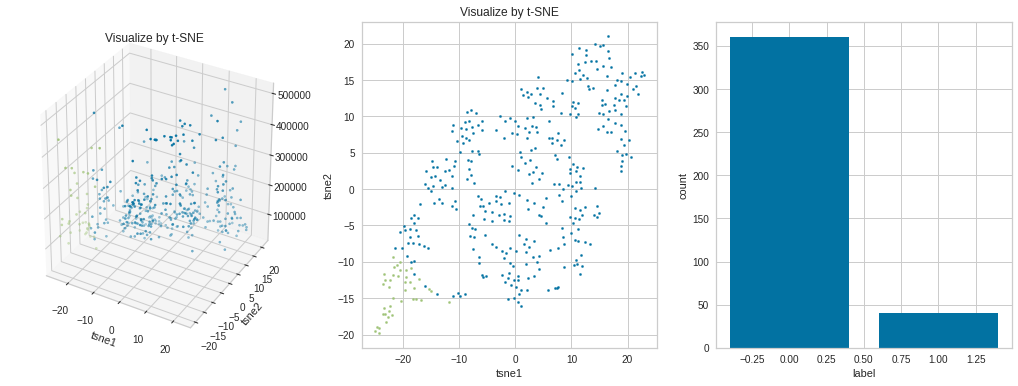




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.25253524594733606


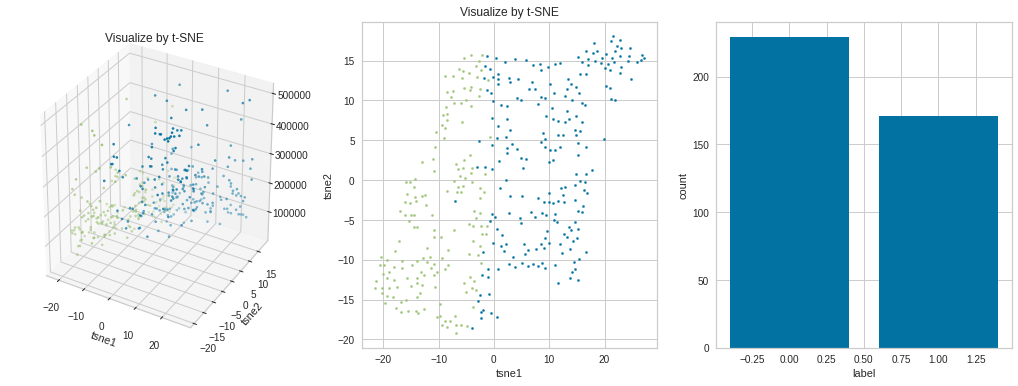




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4
Count labels:  4
Silhouette score:  0.13648109783092802


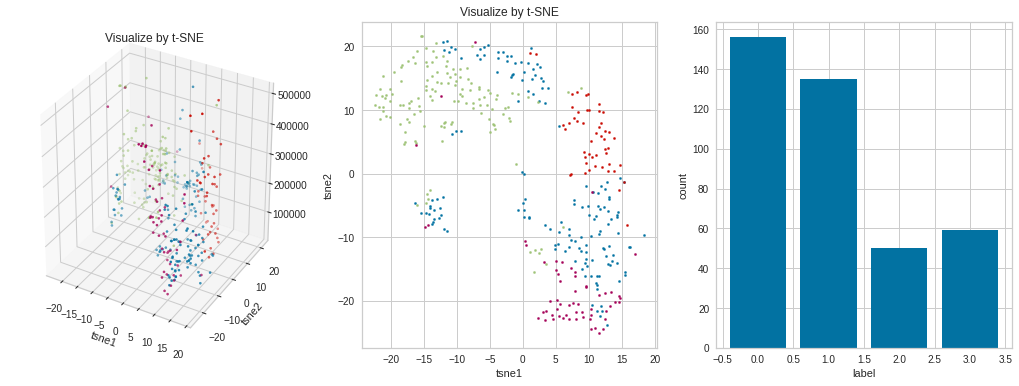




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  4
Count labels:  4
Silhouette score:  0.2561675218948953


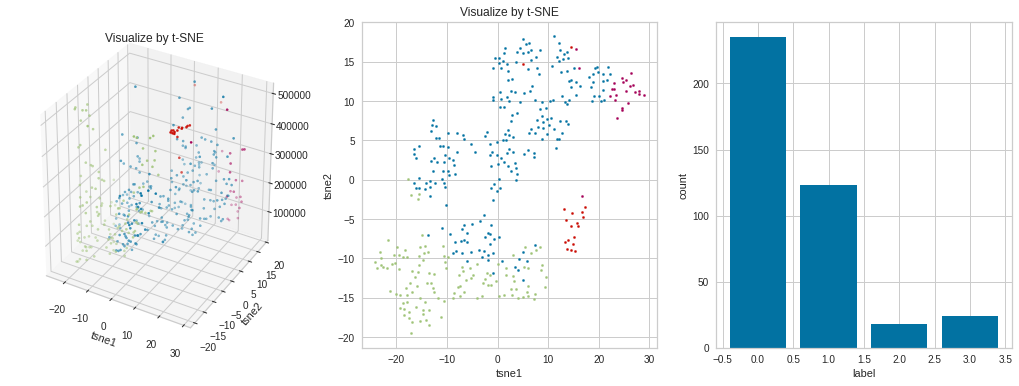




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  4
Count labels:  4
Silhouette score:  0.2730833674584721


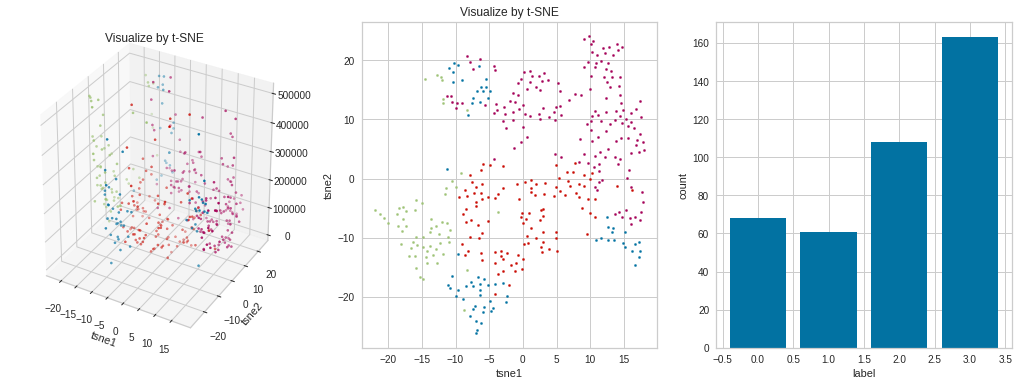




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  6
Count labels:  6
Silhouette score:  0.13463554905306208


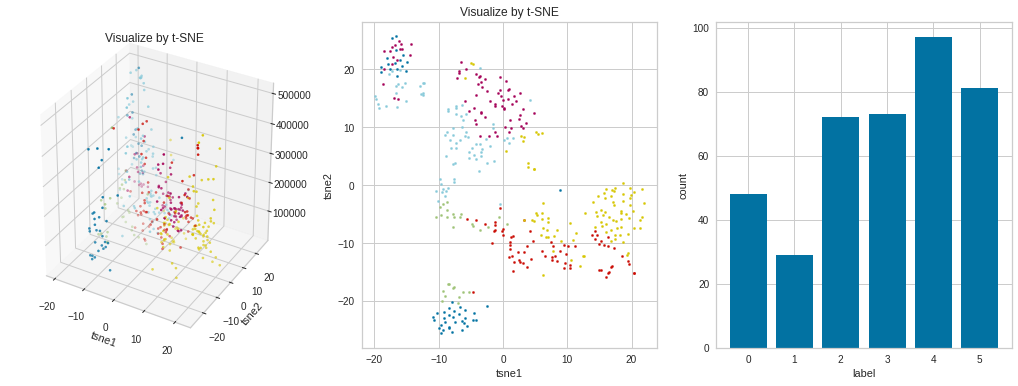




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  6
Count labels:  6
Silhouette score:  0.18743666678736304


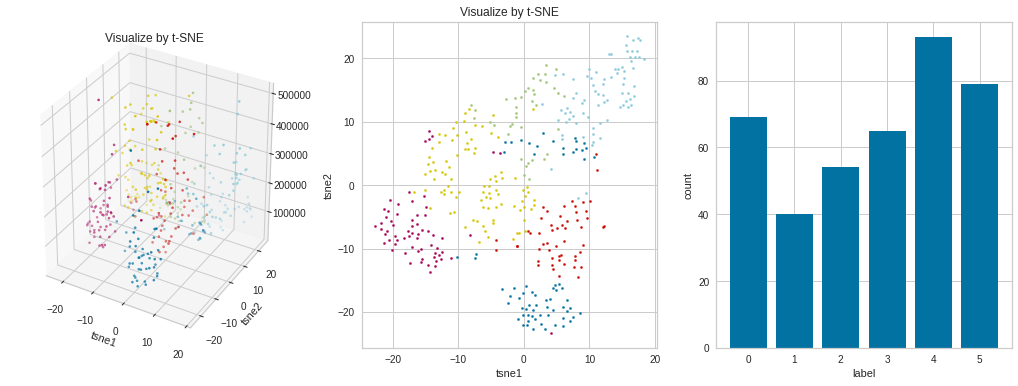




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  6
Count labels:  6
Silhouette score:  0.1493771493260426


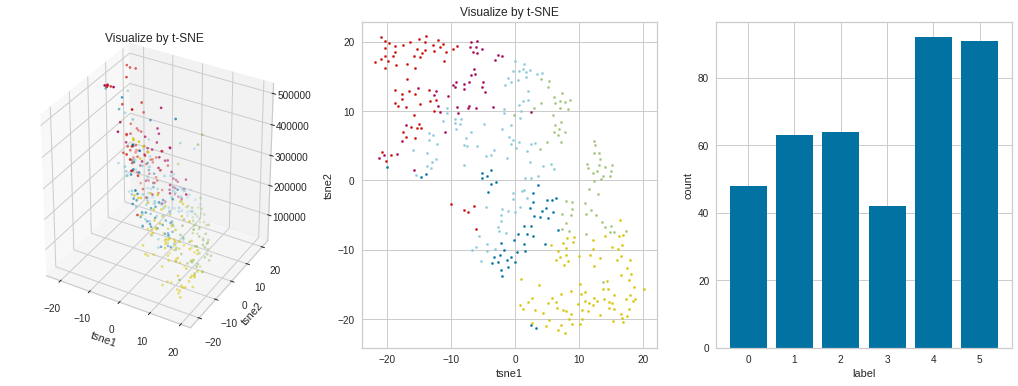




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  8
Count labels:  8
Silhouette score:  0.1646797295739998


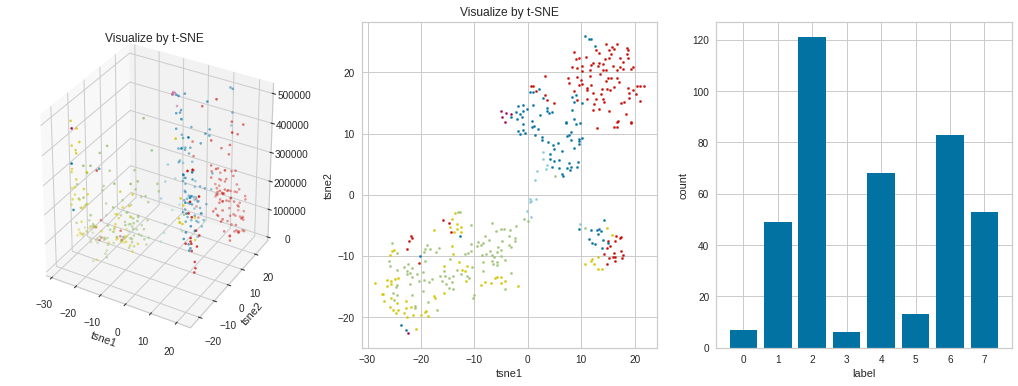




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  8
Count labels:  8
Silhouette score:  0.12877981664914379


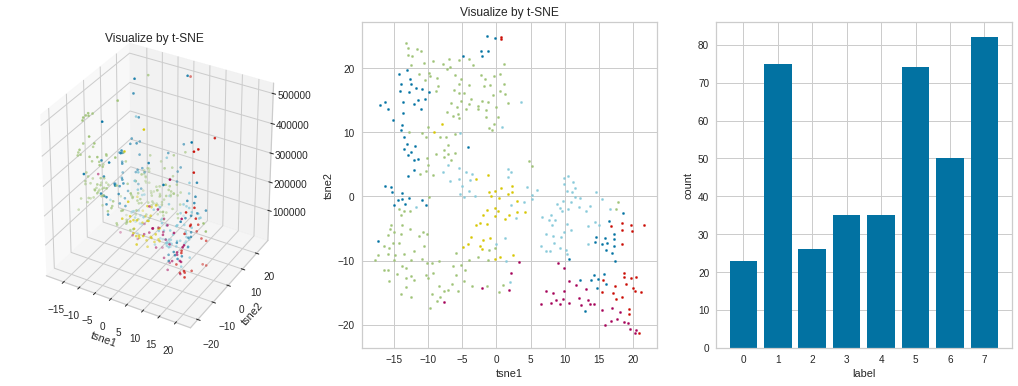




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  8
Count labels:  8
Silhouette score:  0.1177438649943361


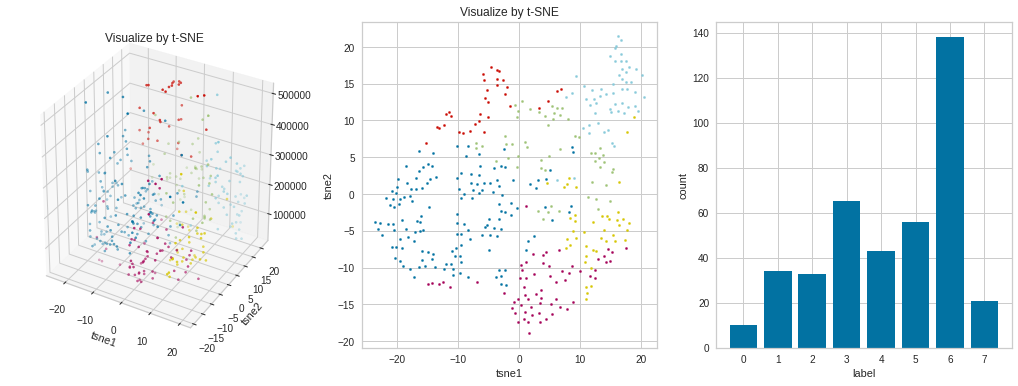




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  10
Count labels:  10
Silhouette score:  0.19725555656580504


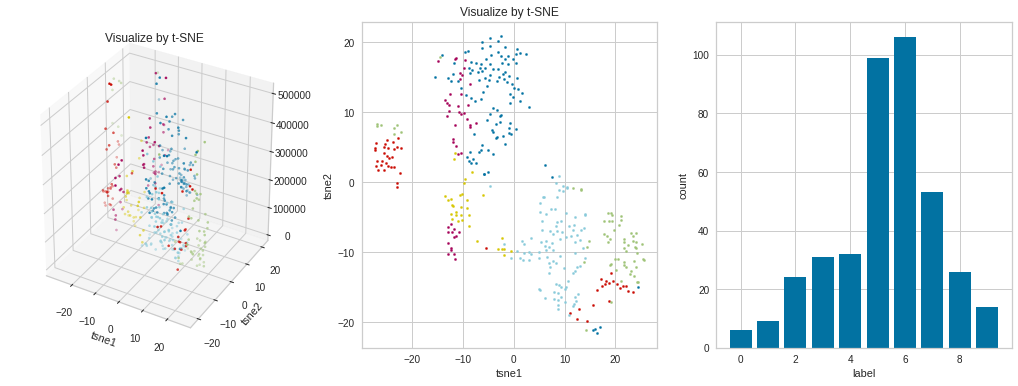




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  10
Count labels:  10
Silhouette score:  0.12521685121763285


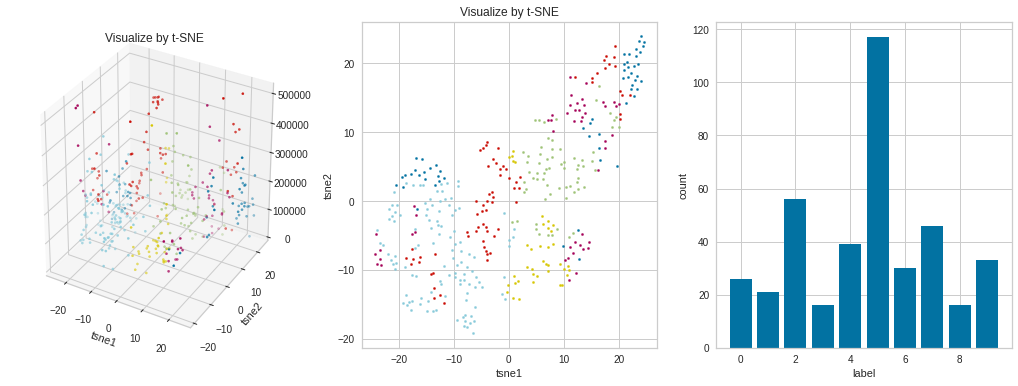




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  10
Count labels:  10
Silhouette score:  0.15573699158808202


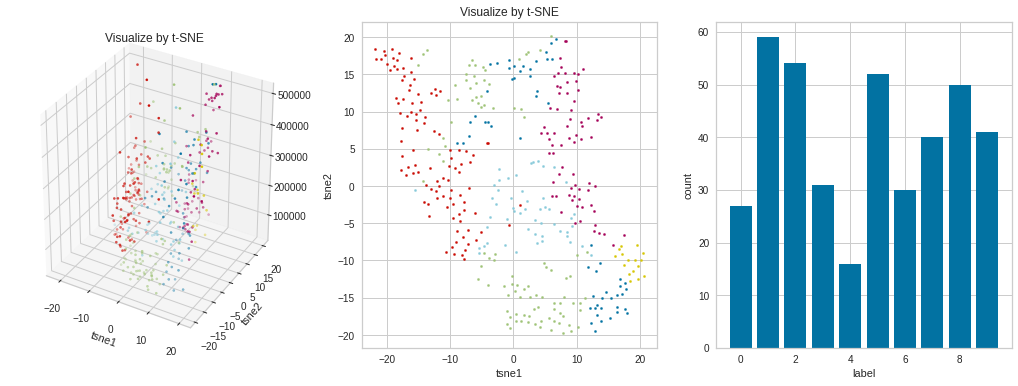




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.24339844492202187


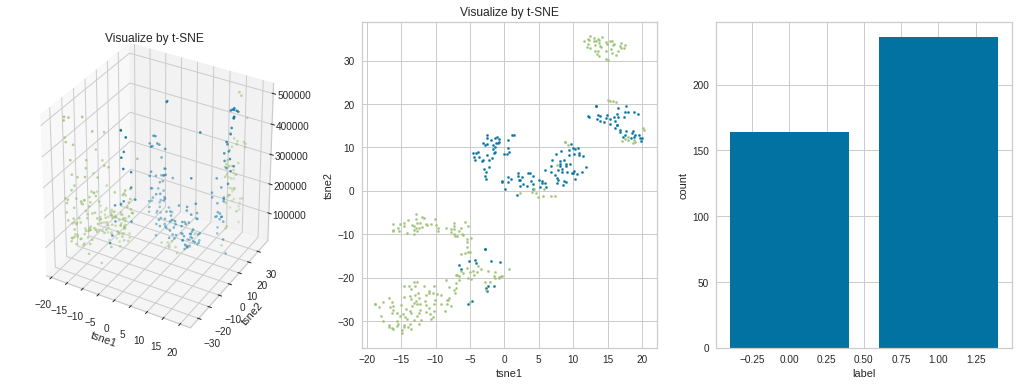




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.2880364898566894


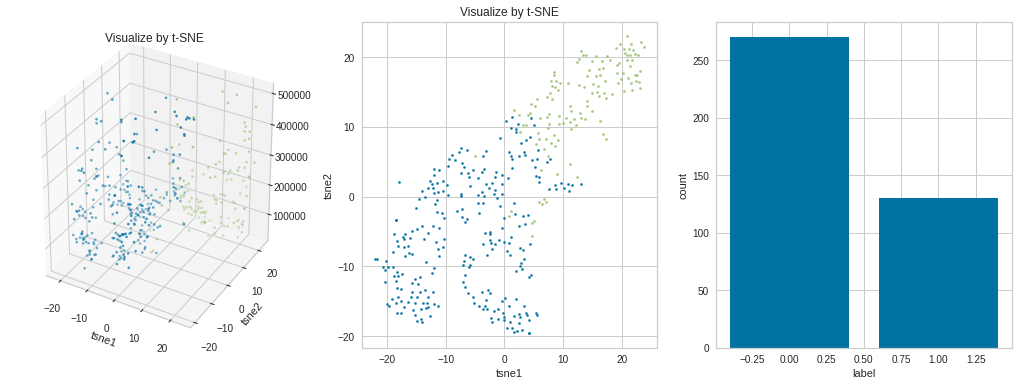




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.3775999908279389


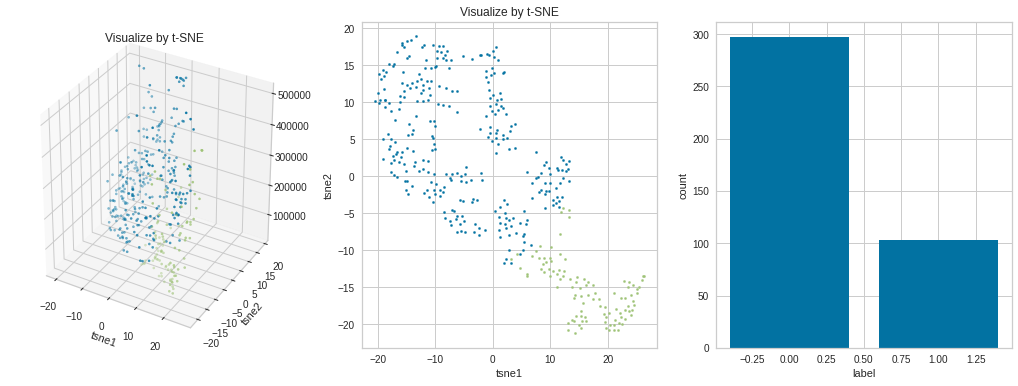




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4
Count labels:  4
Silhouette score:  0.3216671006805815


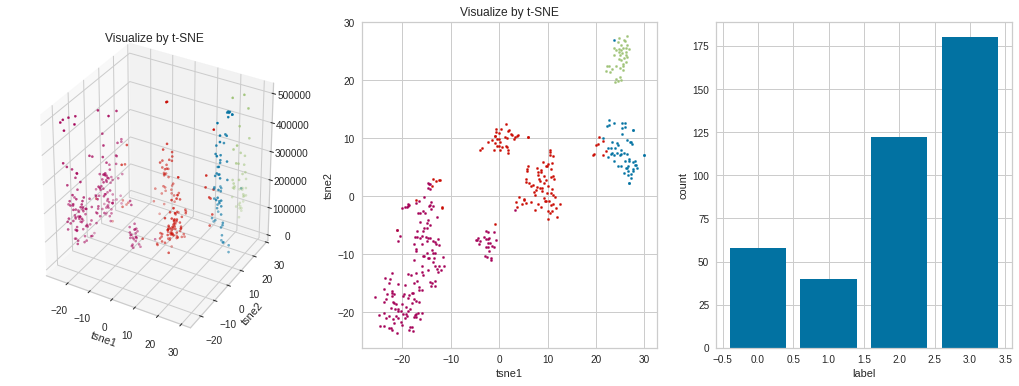




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  4
Count labels:  4
Silhouette score:  0.2693869907537103


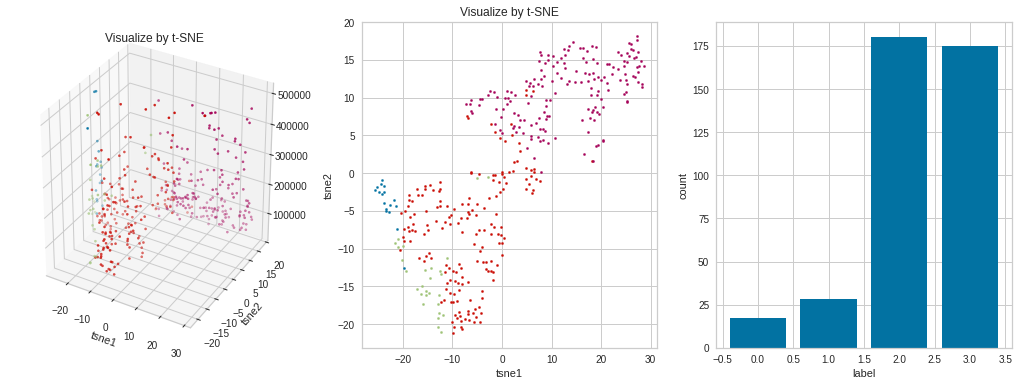




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  4
Count labels:  4
Silhouette score:  0.2677858825002388


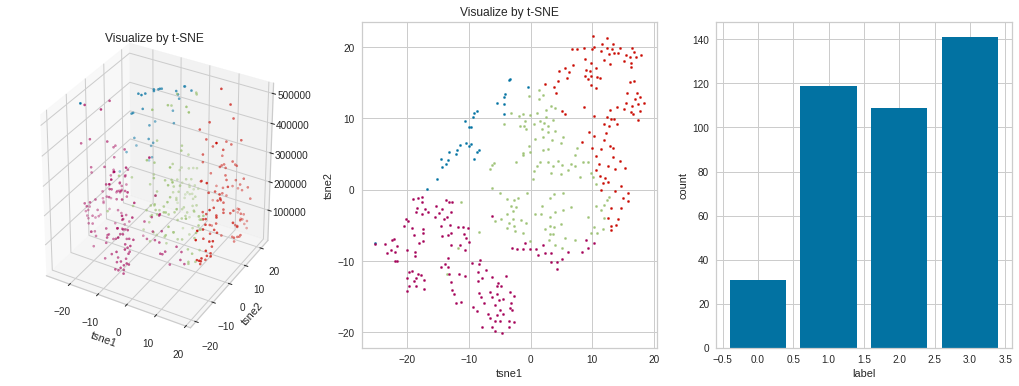




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  6
Count labels:  6
Silhouette score:  0.2593020706445736


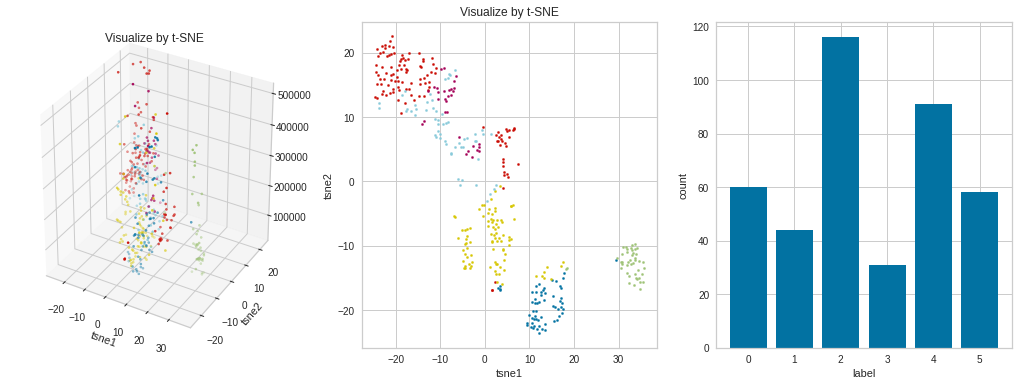




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  6
Count labels:  6
Silhouette score:  0.19869327876274925


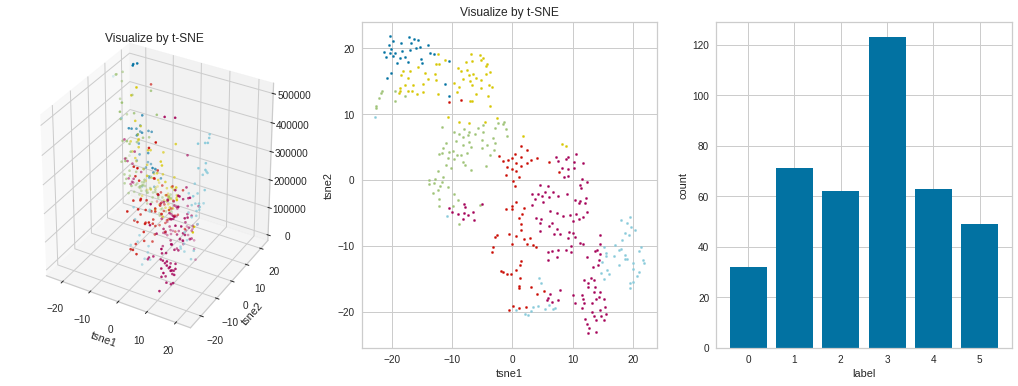




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  6
Count labels:  6
Silhouette score:  0.2305199397685486


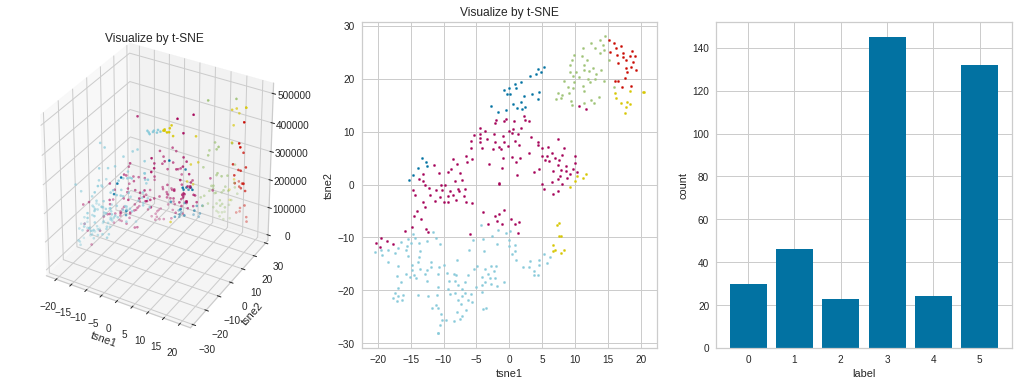




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  8
Count labels:  8
Silhouette score:  0.20935505508821464


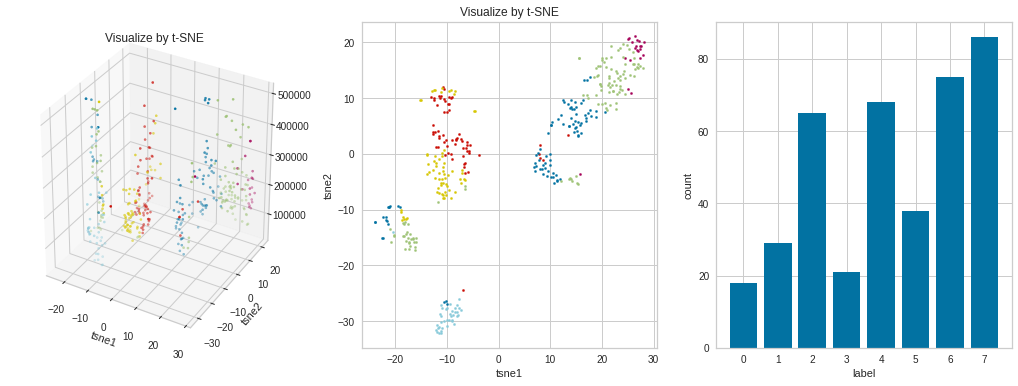




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  8
Count labels:  8
Silhouette score:  0.17283747525578724


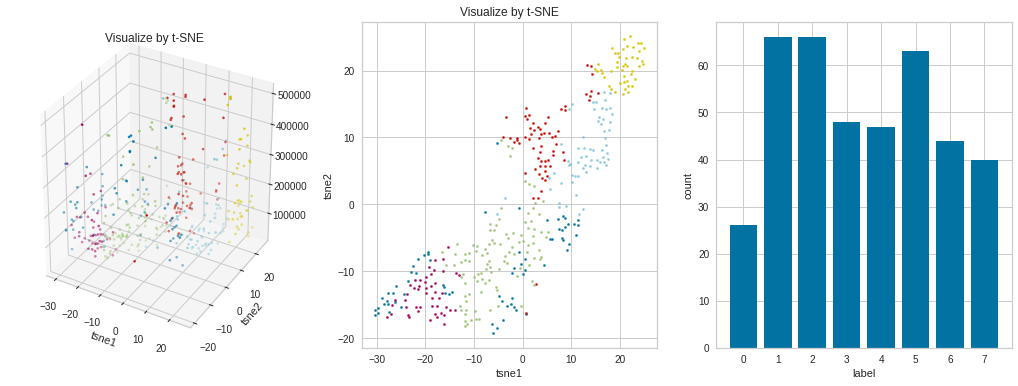




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  8
Count labels:  8
Silhouette score:  0.23100297138960166


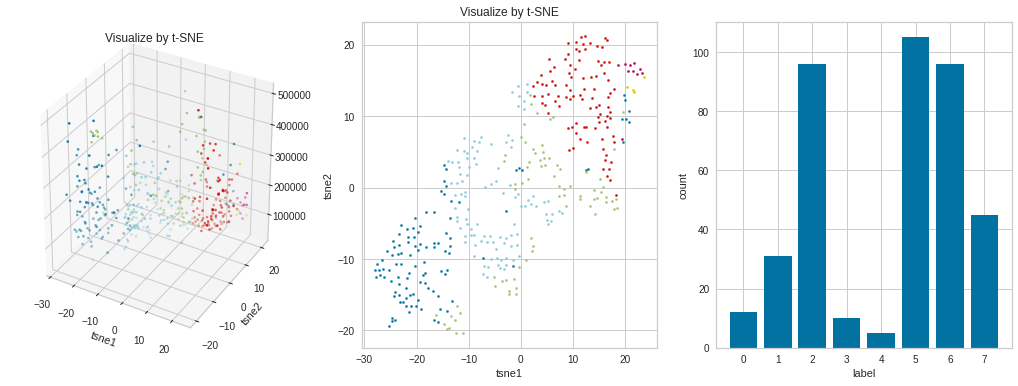




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  10
Count labels:  10
Silhouette score:  0.16142641632392019


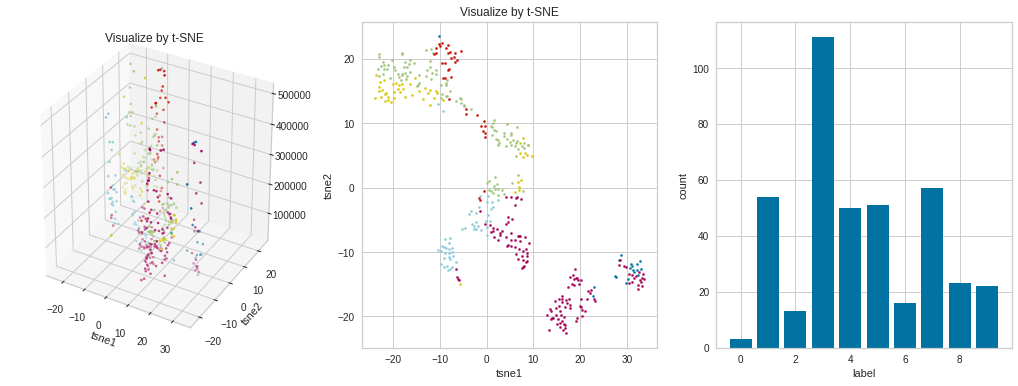




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  10
Count labels:  10
Silhouette score:  0.11913314050859956


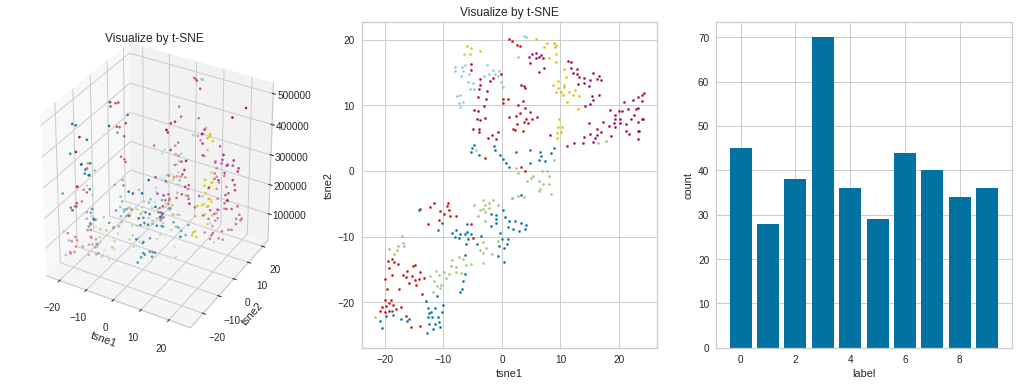




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  10
Count labels:  10
Silhouette score:  0.14655095131086765


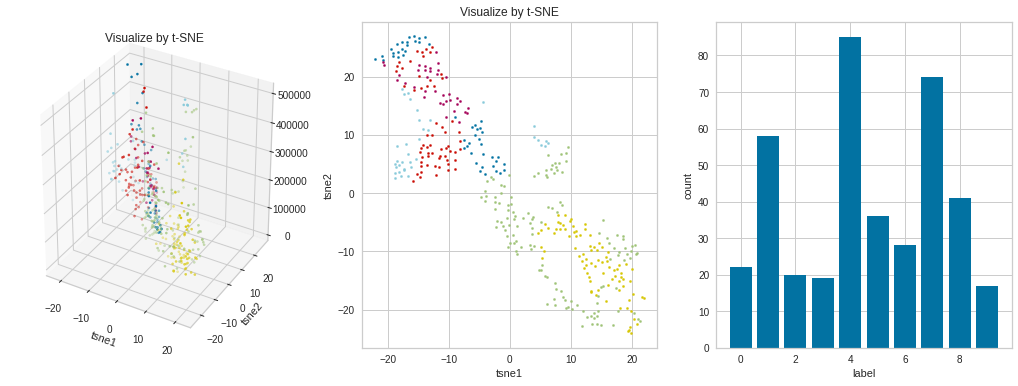




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.12776253470339352


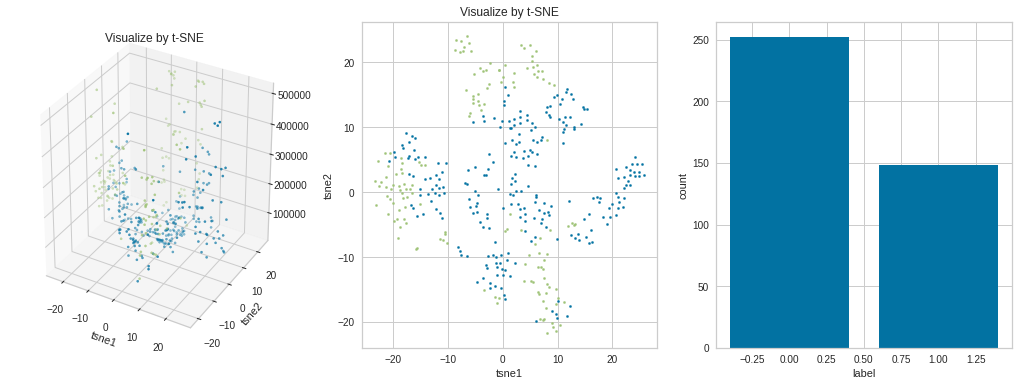




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.4437341756625278


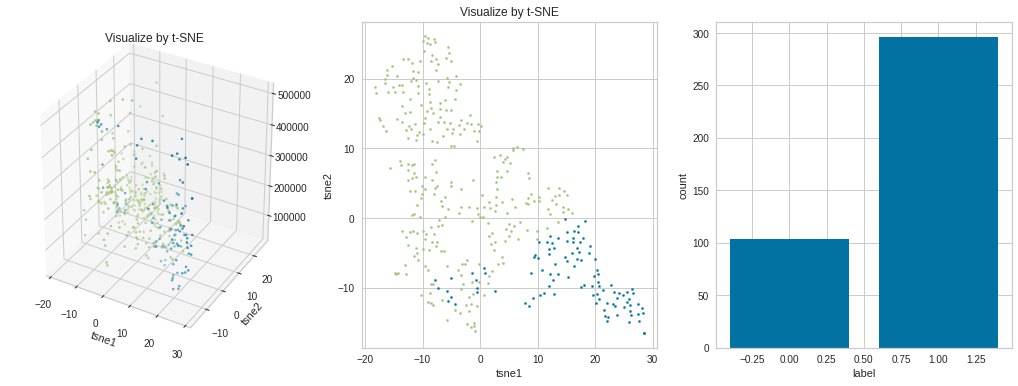




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.37768956556377214


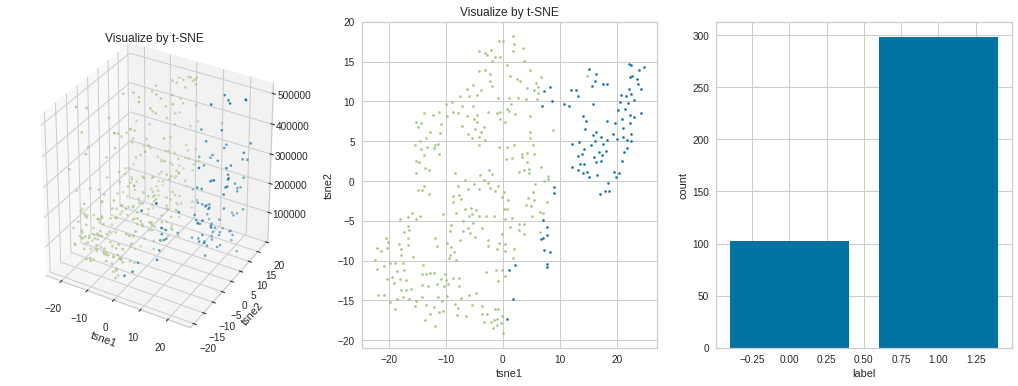




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4
Count labels:  4
Silhouette score:  0.1387014142732129


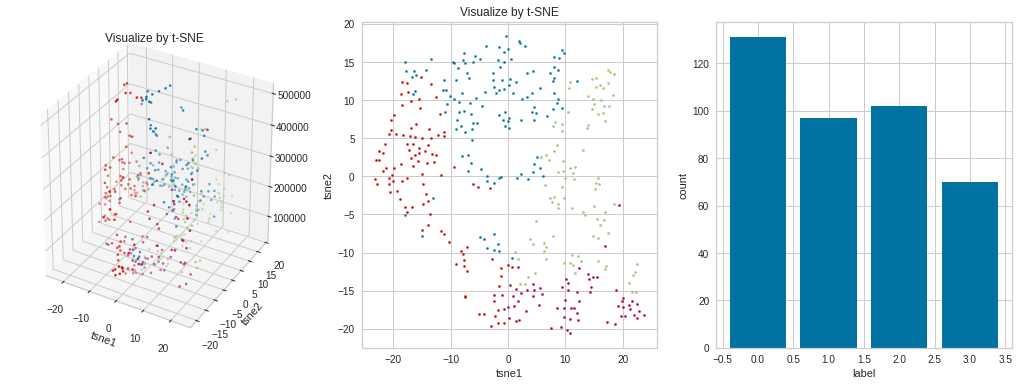




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  4
Count labels:  4
Silhouette score:  0.34089307749785336


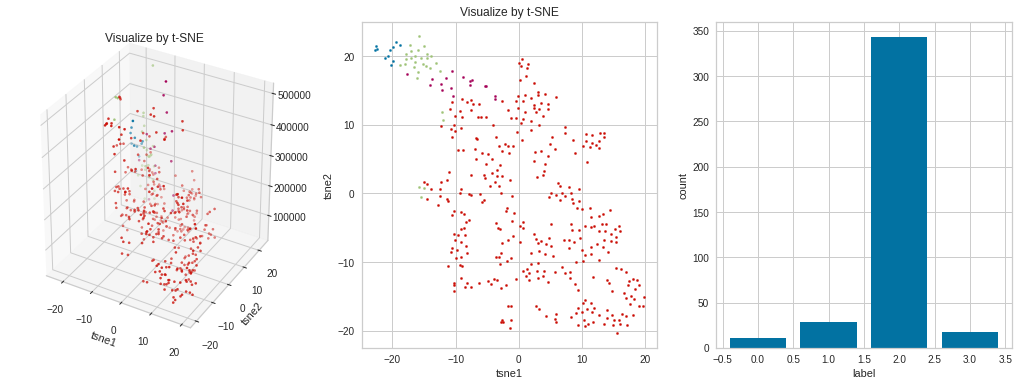




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  4
Count labels:  4
Silhouette score:  0.212289384554388


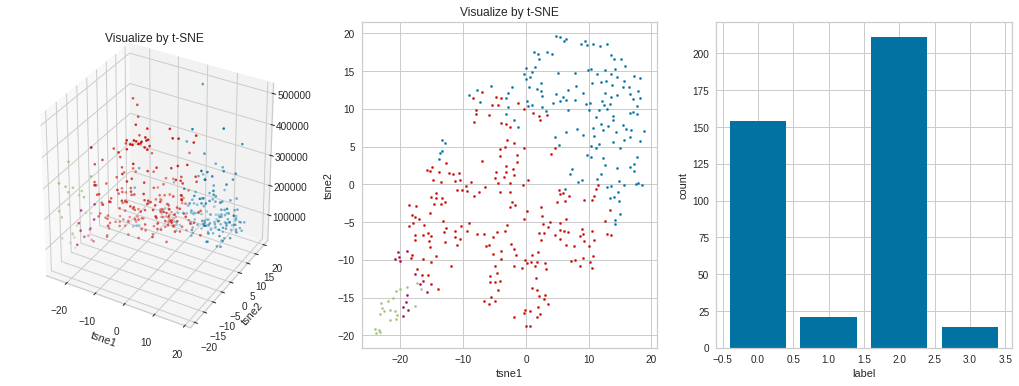




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  6
Count labels:  6
Silhouette score:  0.11617517702949445


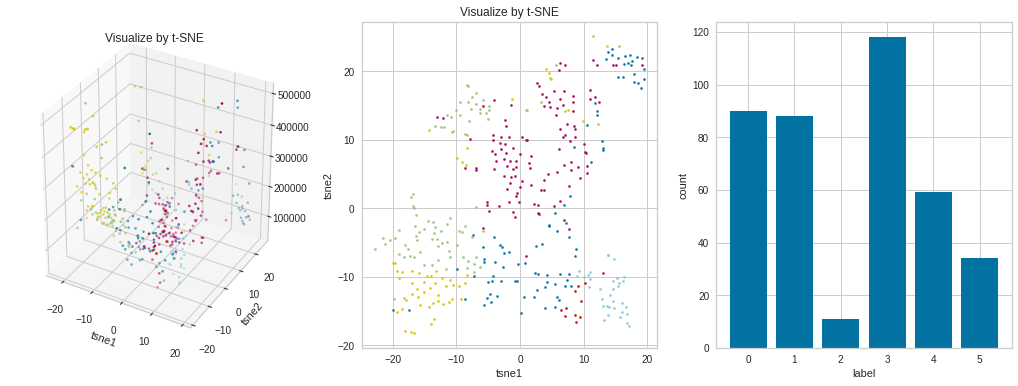




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  6
Count labels:  6
Silhouette score:  0.22172680322382604


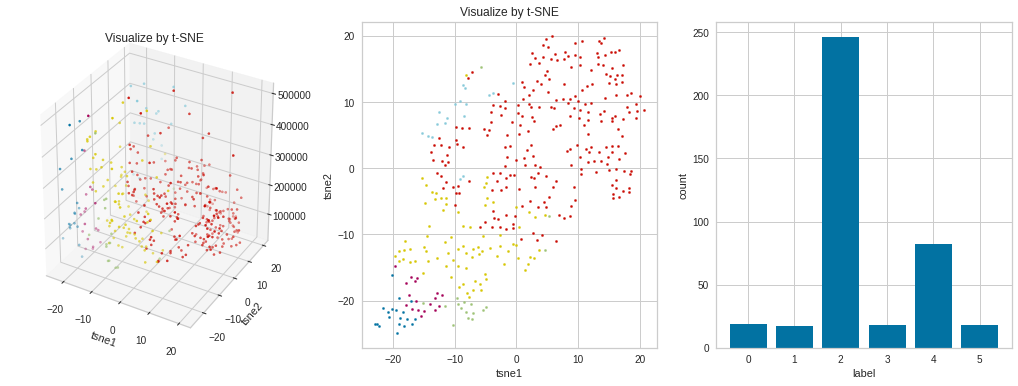




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  6
Count labels:  6
Silhouette score:  0.11494521756451313


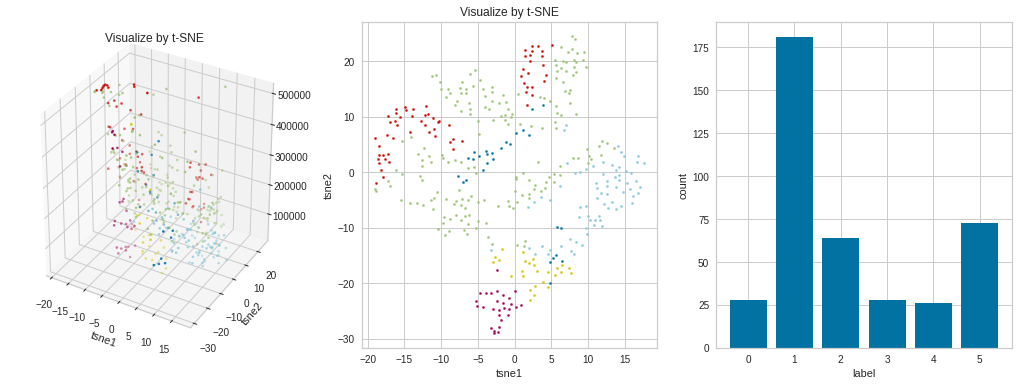




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  8
Count labels:  8
Silhouette score:  0.09437222915814023


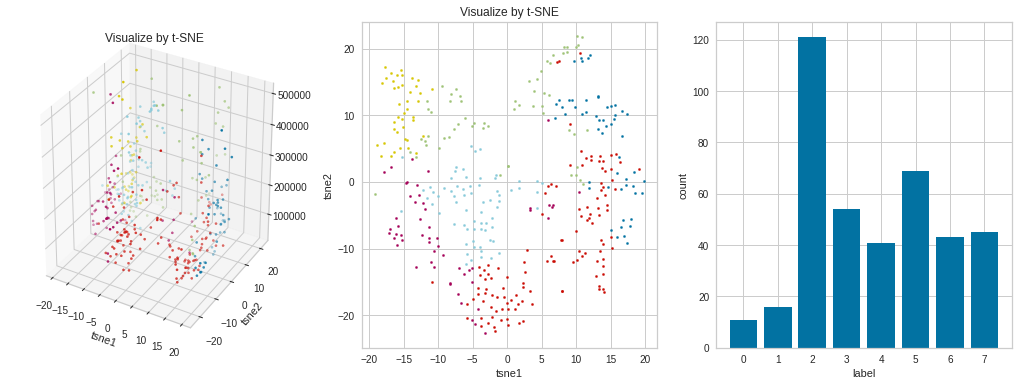




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  8
Count labels:  8
Silhouette score:  0.1381541116275465


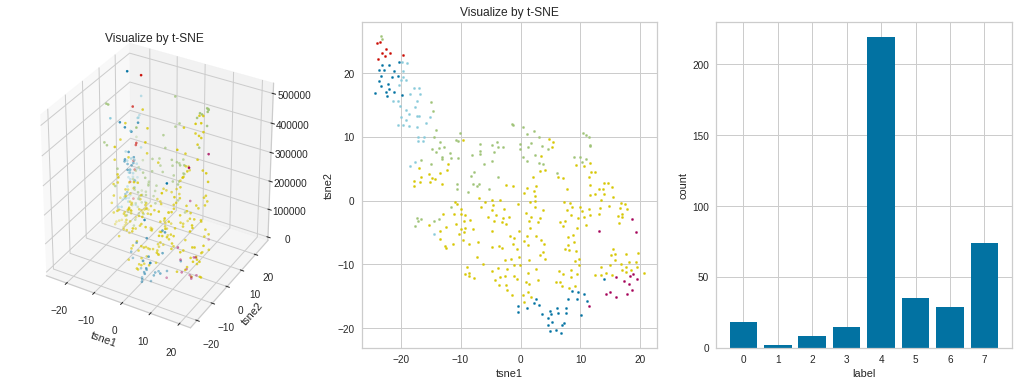




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  8
Count labels:  8
Silhouette score:  0.16330363719014174


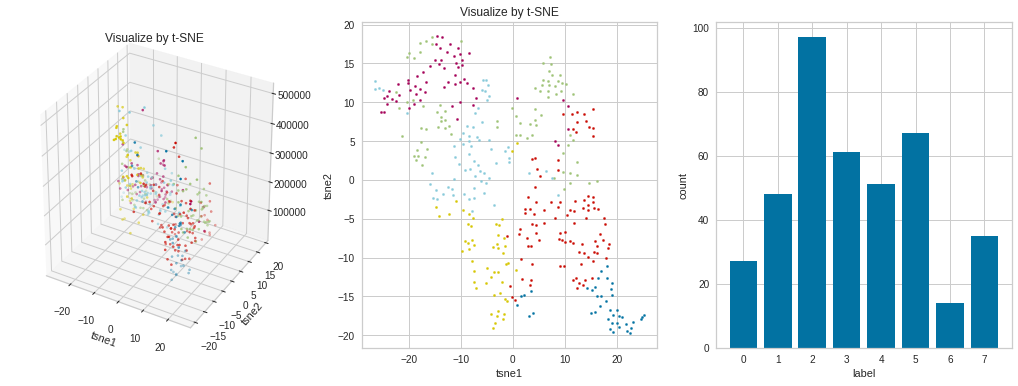




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  10
Count labels:  10
Silhouette score:  0.09028757528812742


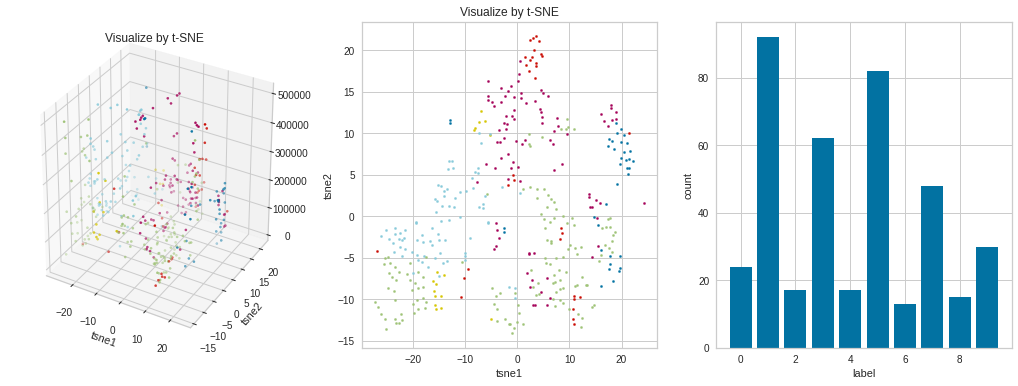




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  10
Count labels:  10
Silhouette score:  0.15963159804128554


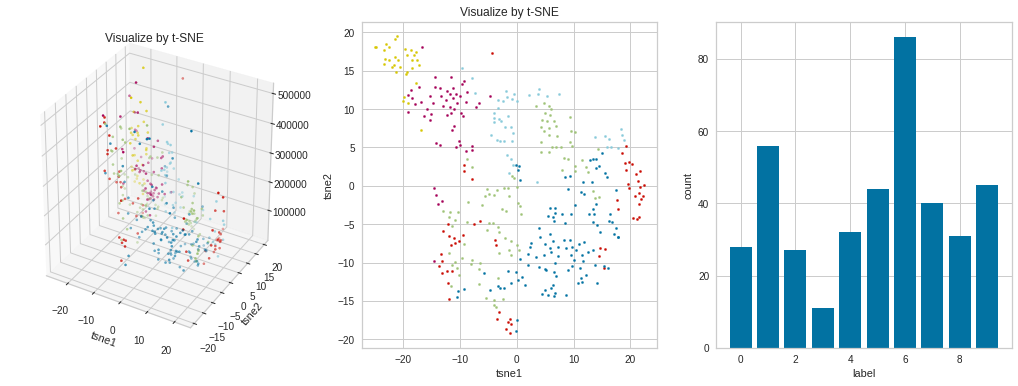




Model:  CLARANS
Encoder:  LabelEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  10
Count labels:  10
Silhouette score:  0.08560577612846294


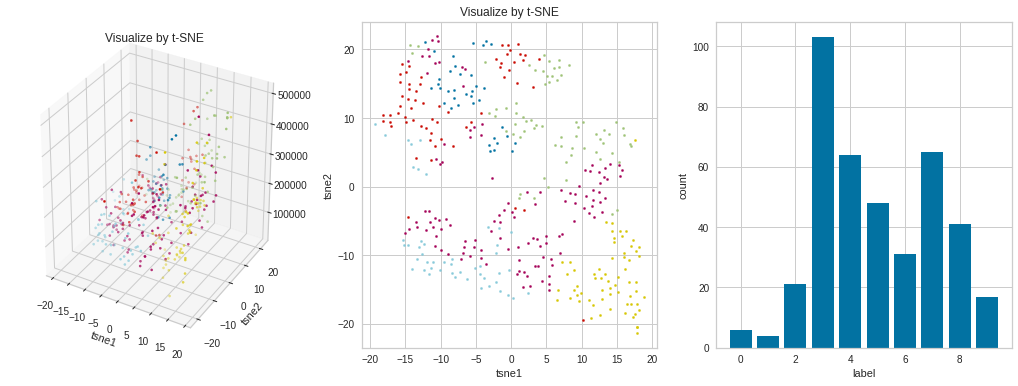




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.20354281236483004


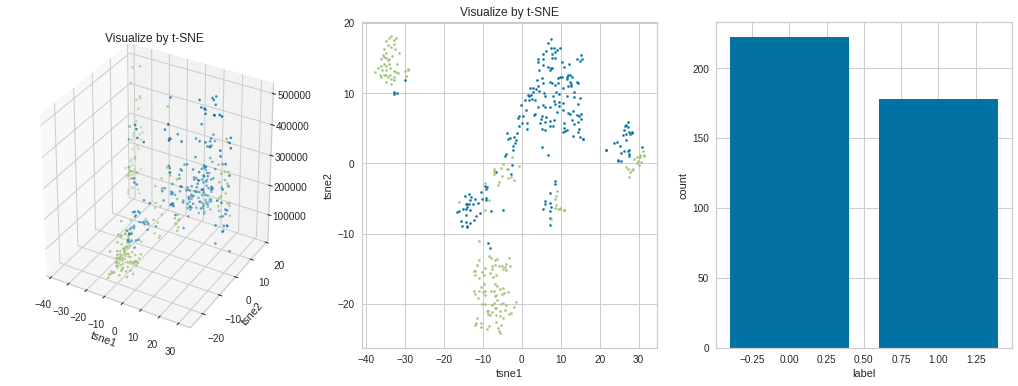




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.21814851215490805


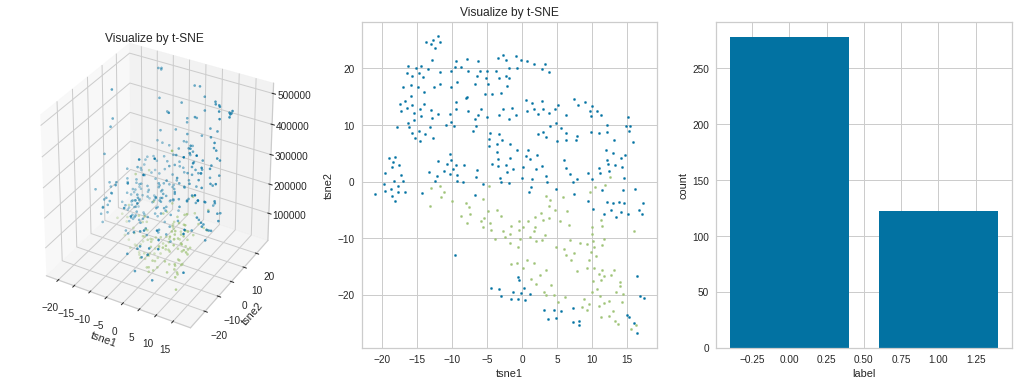




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.28394590051405727


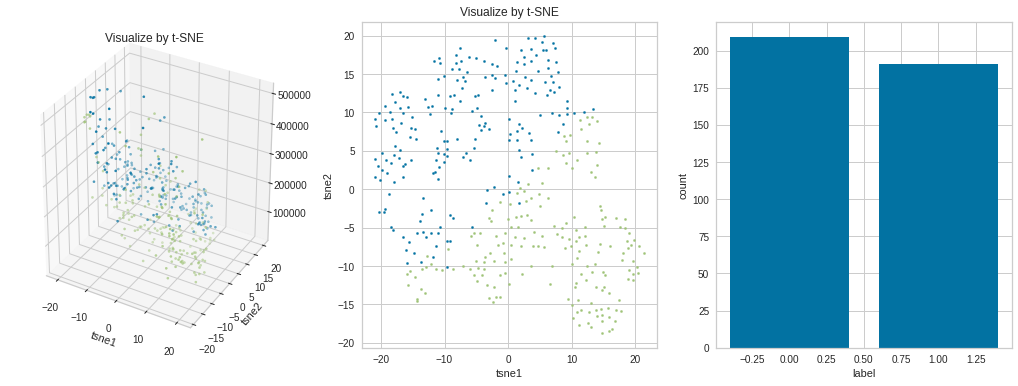




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4
Count labels:  4
Silhouette score:  0.1567953262436107


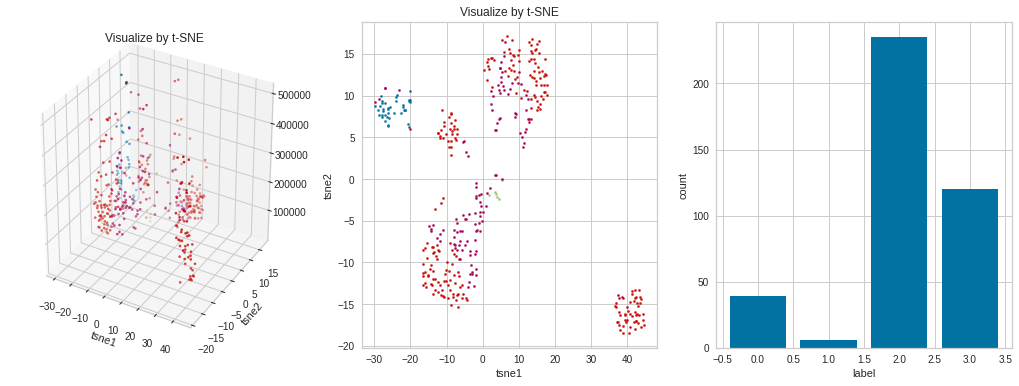




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  4
Count labels:  4
Silhouette score:  0.1652326712480664


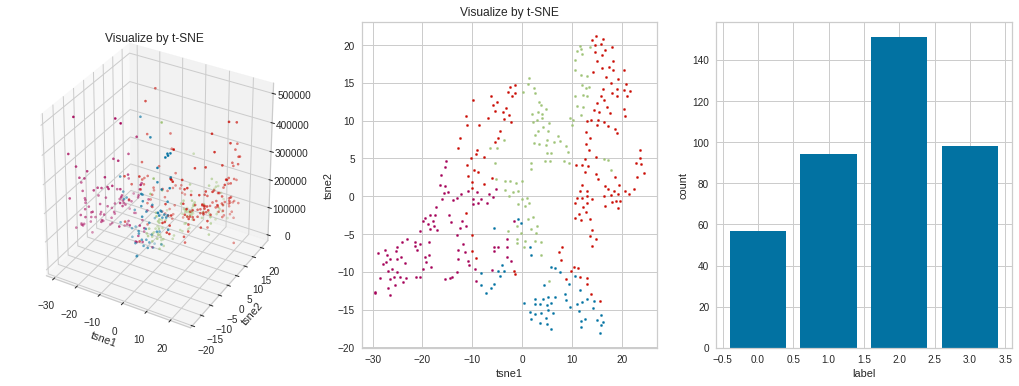




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  4
Count labels:  4
Silhouette score:  0.1771149977776767


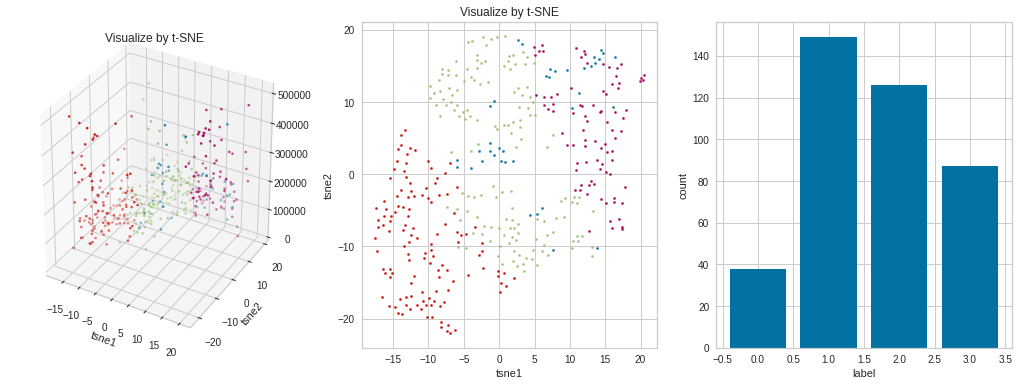




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  6
Count labels:  6
Silhouette score:  0.20122497816141494


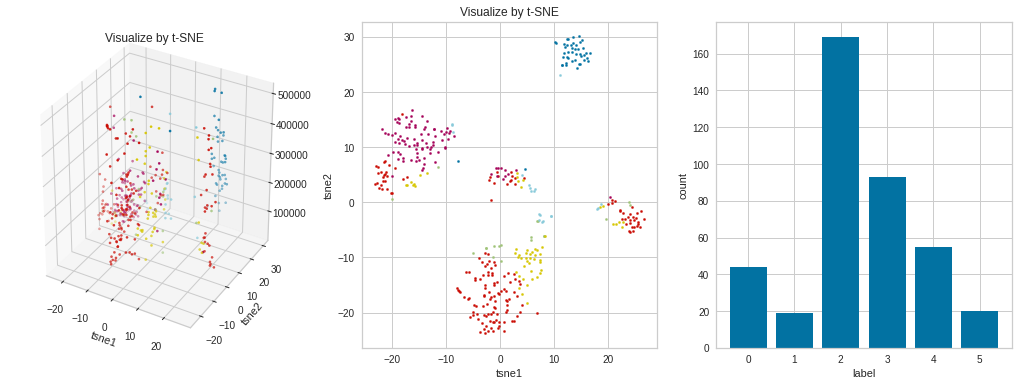




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  6
Count labels:  6
Silhouette score:  0.14741324869766653


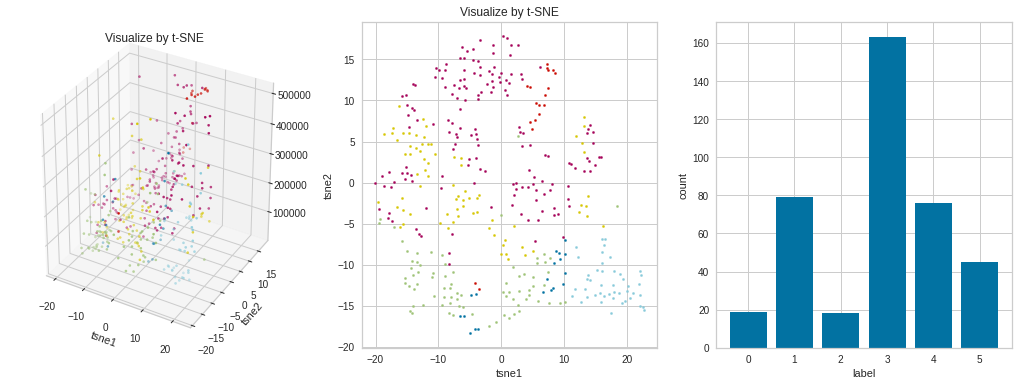




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  6
Count labels:  6
Silhouette score:  0.14740597943876682


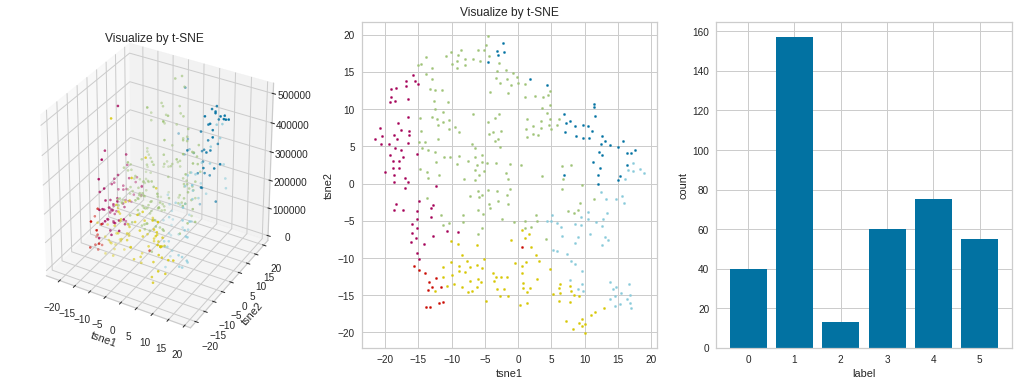




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  8
Count labels:  8
Silhouette score:  0.2388574459249938


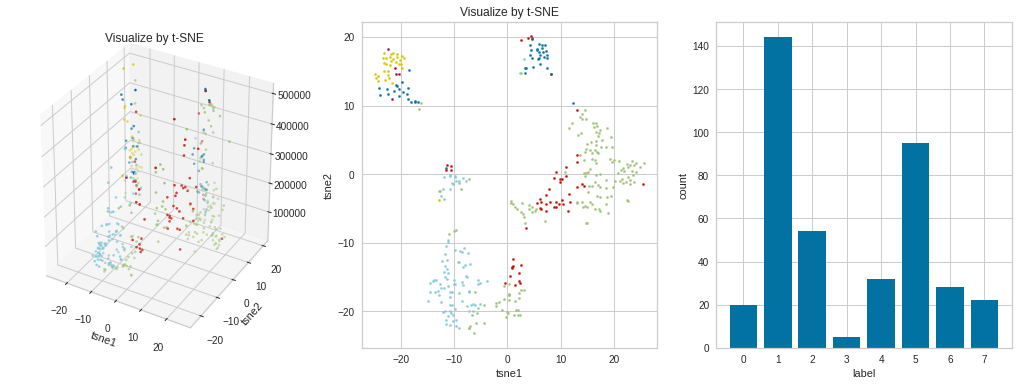




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  8
Count labels:  8
Silhouette score:  0.1690250858884574


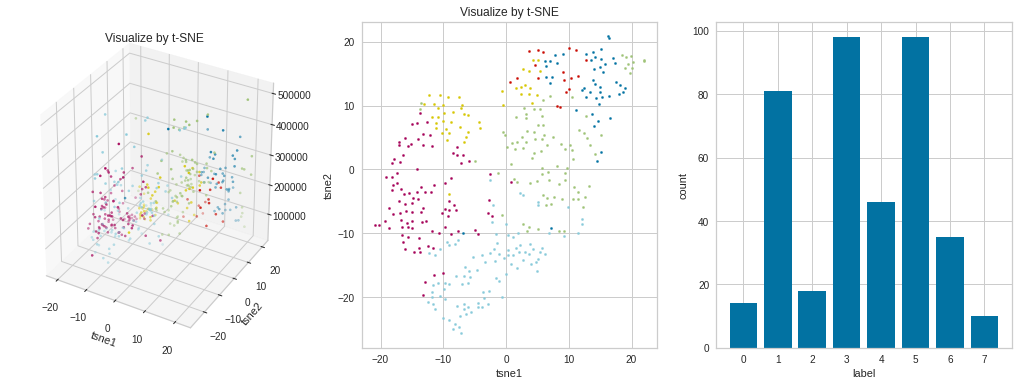




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  8
Count labels:  8
Silhouette score:  0.1487832259230281


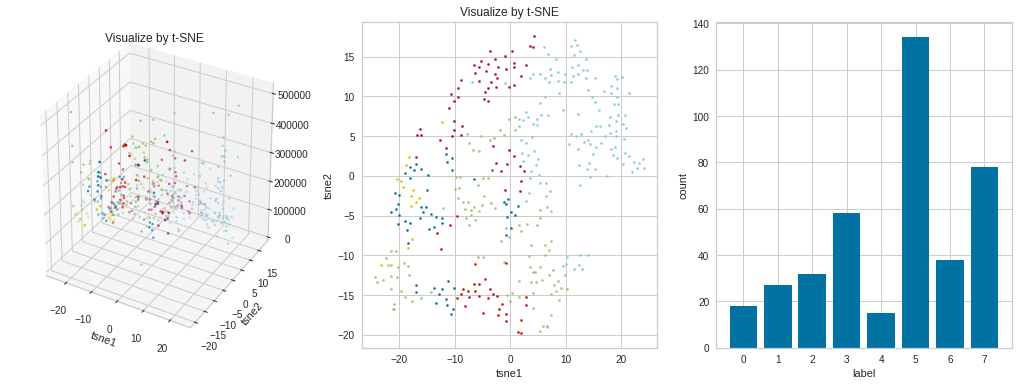




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  10
Count labels:  10
Silhouette score:  0.1664765353953539


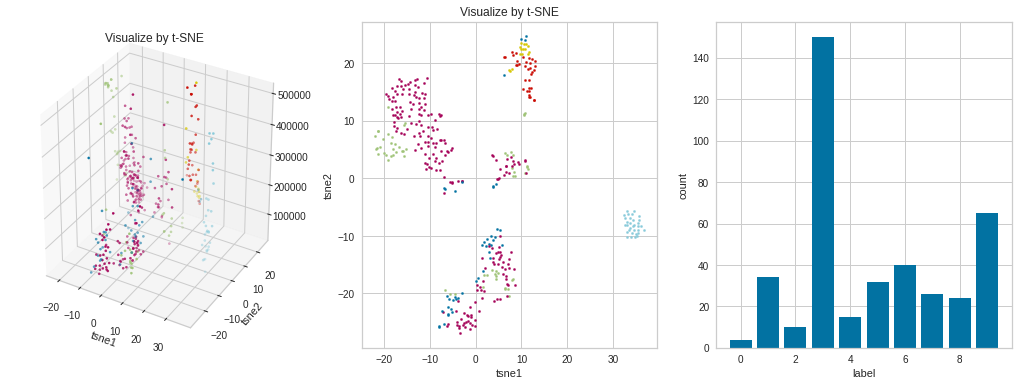




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  10
Count labels:  10
Silhouette score:  0.15876645554865518


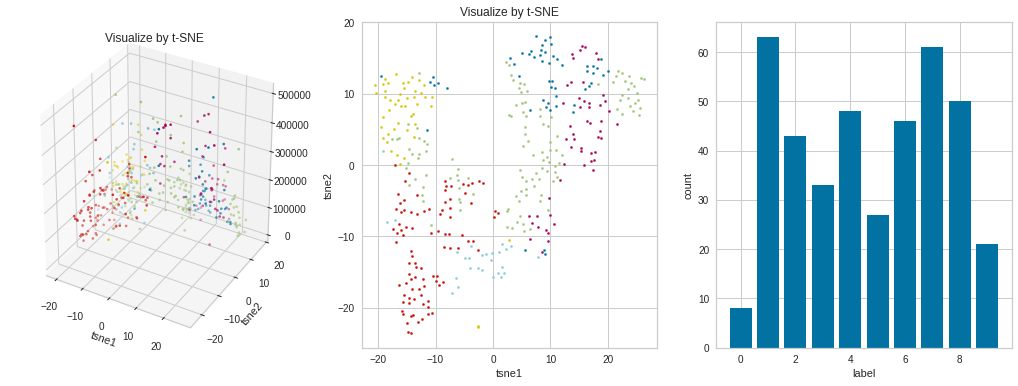




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  StandardScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  10
Count labels:  10
Silhouette score:  0.15315083981829525


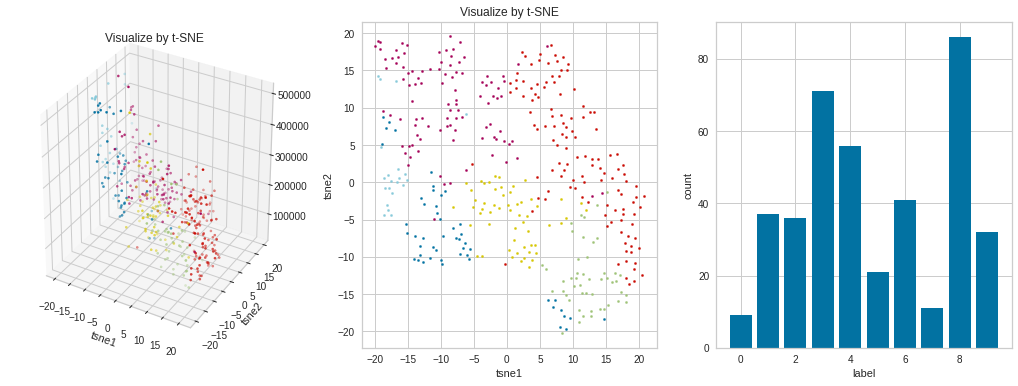




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.37405590322624577


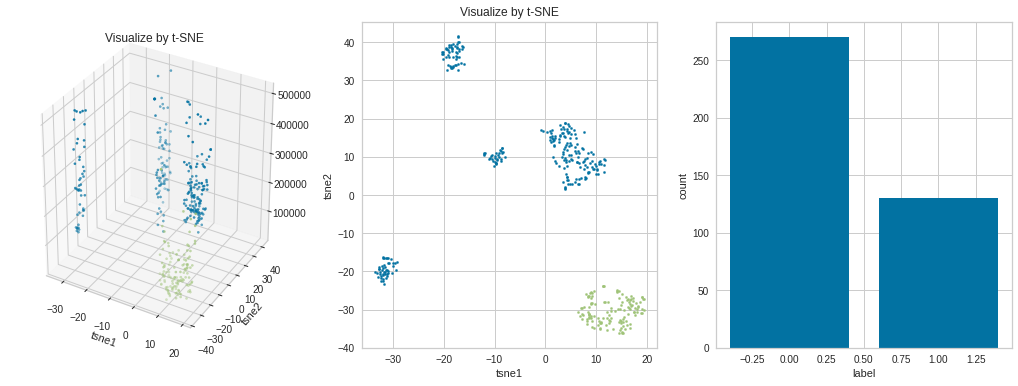




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.3222390800592116


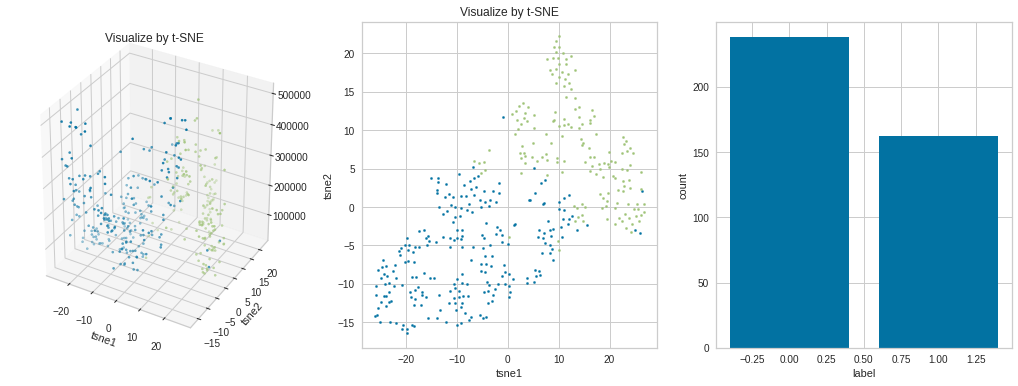




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.25478871162424965


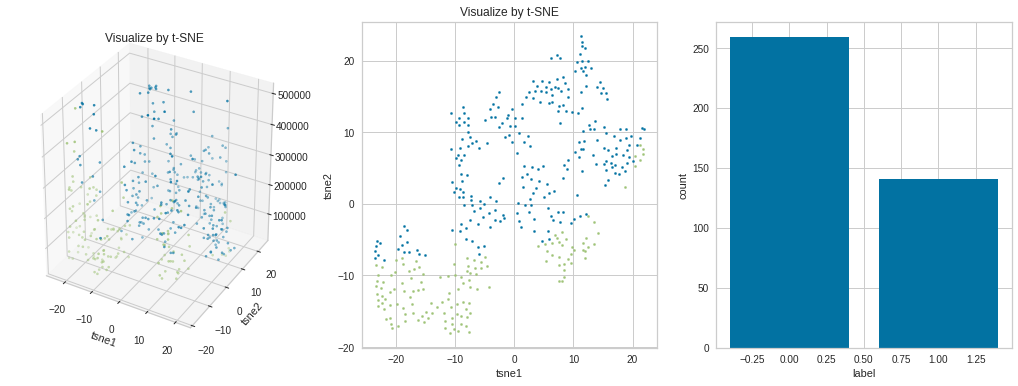




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4
Count labels:  4
Silhouette score:  0.46078835895114084


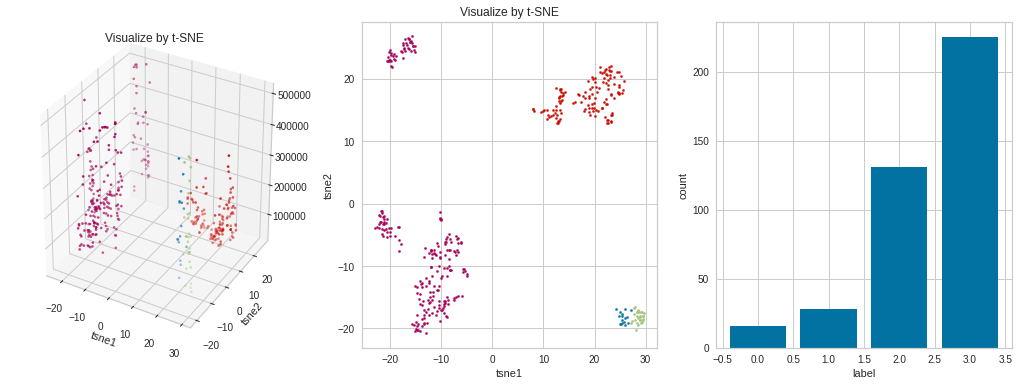




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  4
Count labels:  4
Silhouette score:  0.3133569142739692


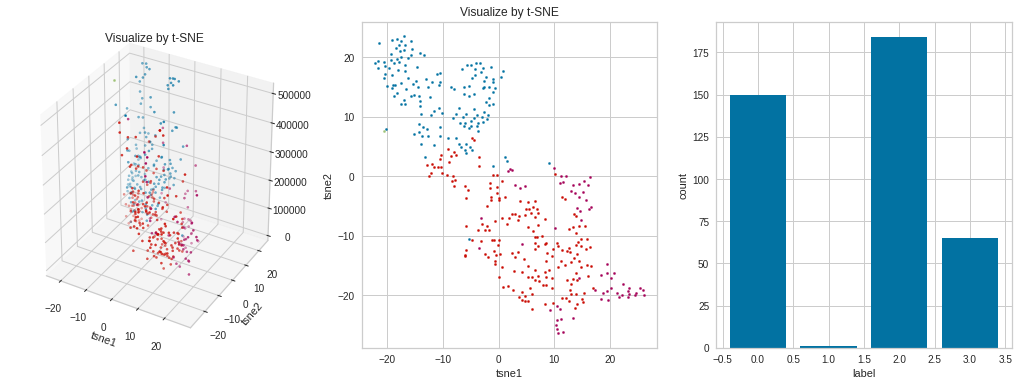




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  4
Count labels:  4
Silhouette score:  0.23675626774430697


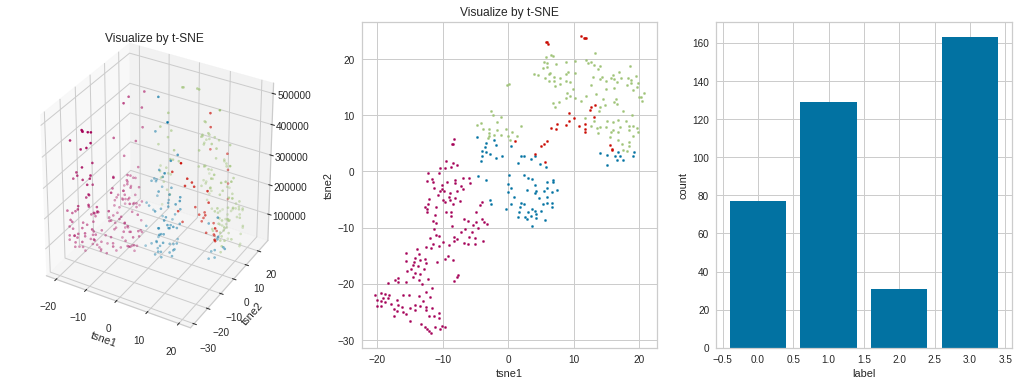




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  6
Count labels:  6
Silhouette score:  0.4471544332131305


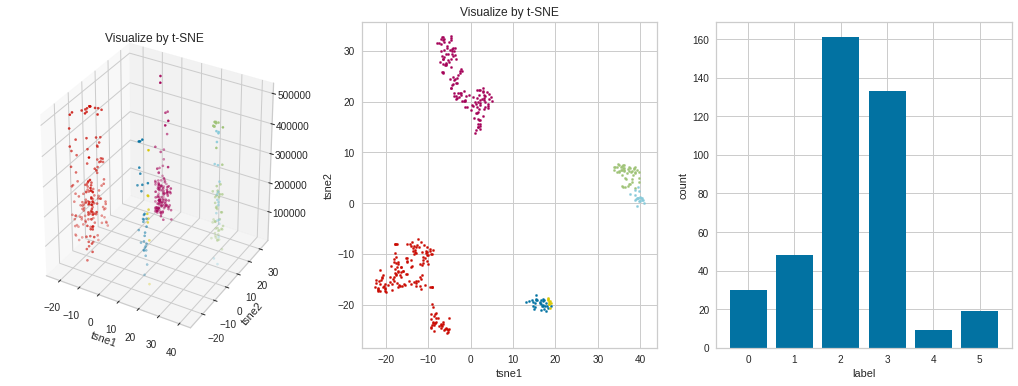




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  6
Count labels:  6
Silhouette score:  0.1284683125277532


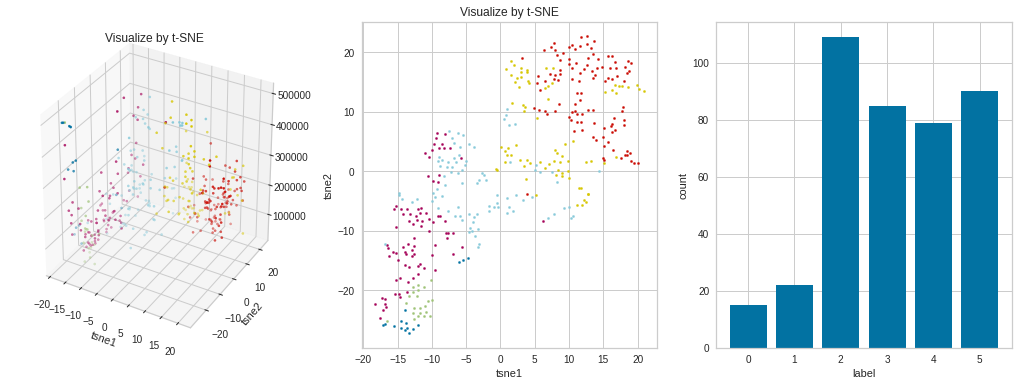




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  6
Count labels:  6
Silhouette score:  0.2410687759930763


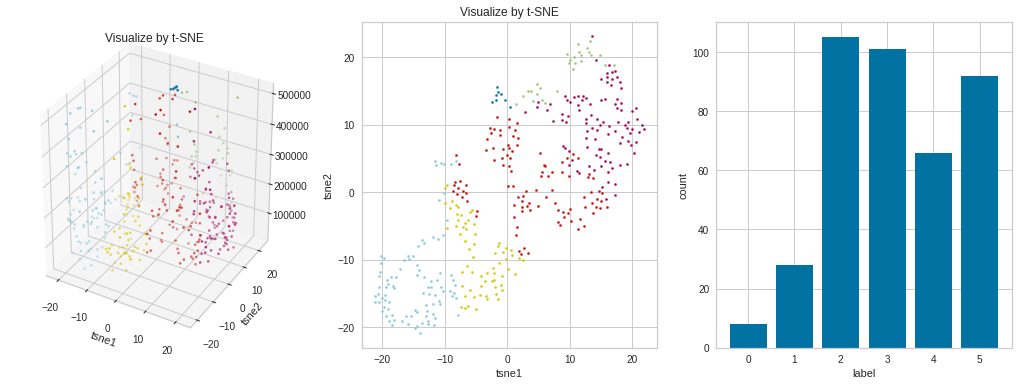




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  8
Count labels:  8
Silhouette score:  0.4160292149927102


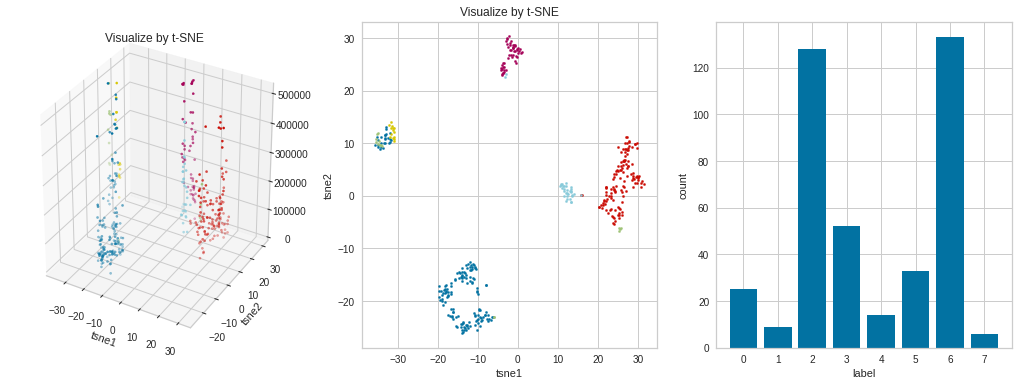




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  8
Count labels:  8
Silhouette score:  0.23493092755005157


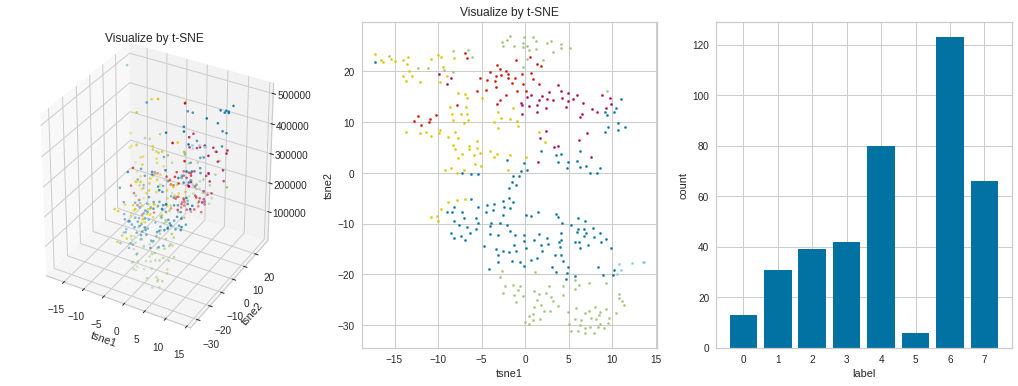




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  8
Count labels:  8
Silhouette score:  0.21365802162023104


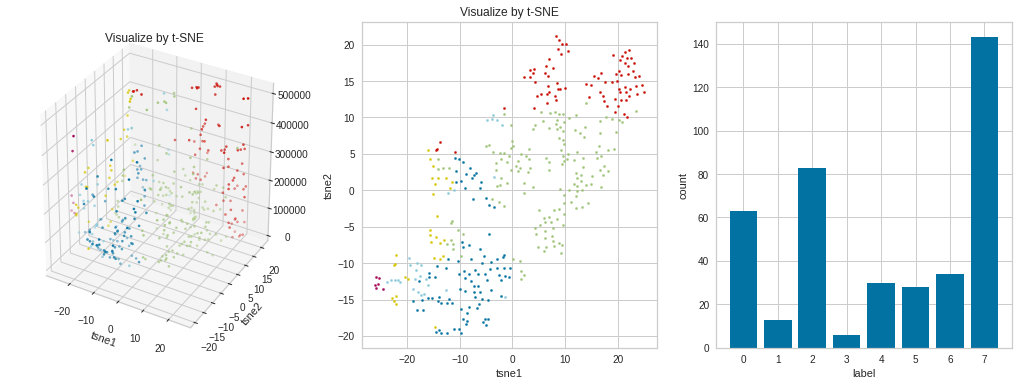




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  10
Count labels:  10
Silhouette score:  0.3122097661448229


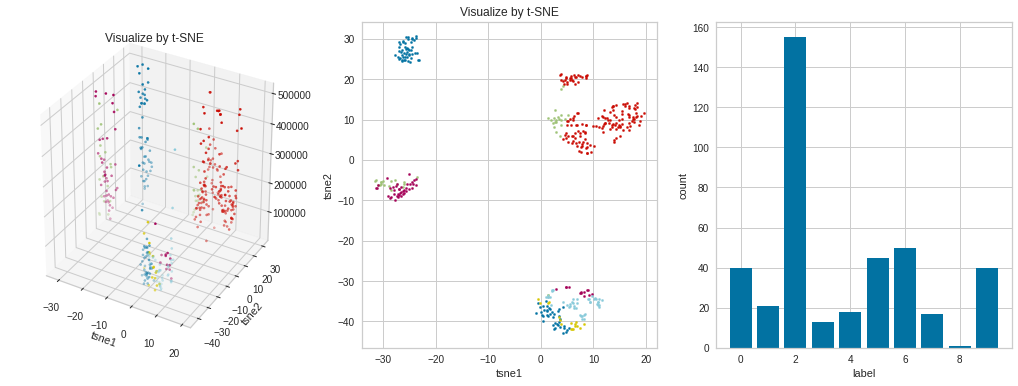




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  10
Count labels:  10
Silhouette score:  0.13466292932958726


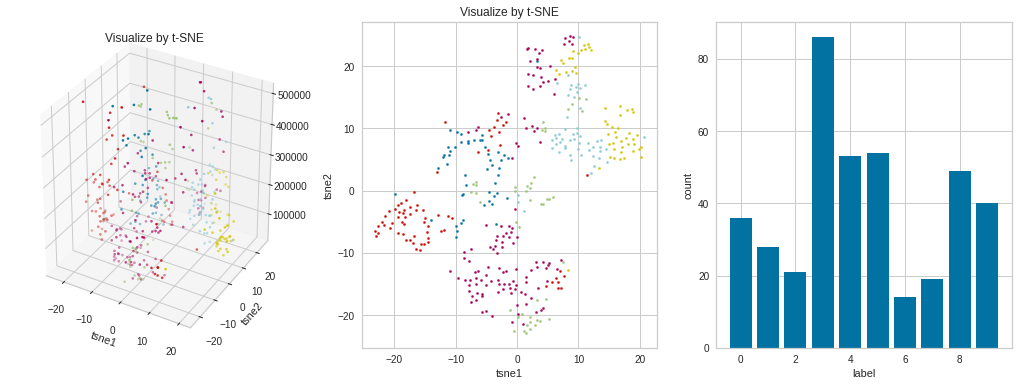




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  MinMaxScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  10
Count labels:  10
Silhouette score:  0.2215188410075834


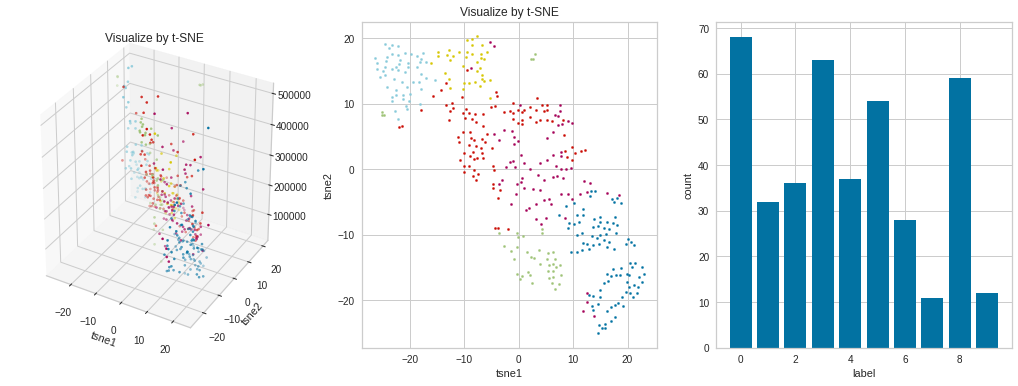




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  2
Count labels:  2
Silhouette score:  0.18595671575970157


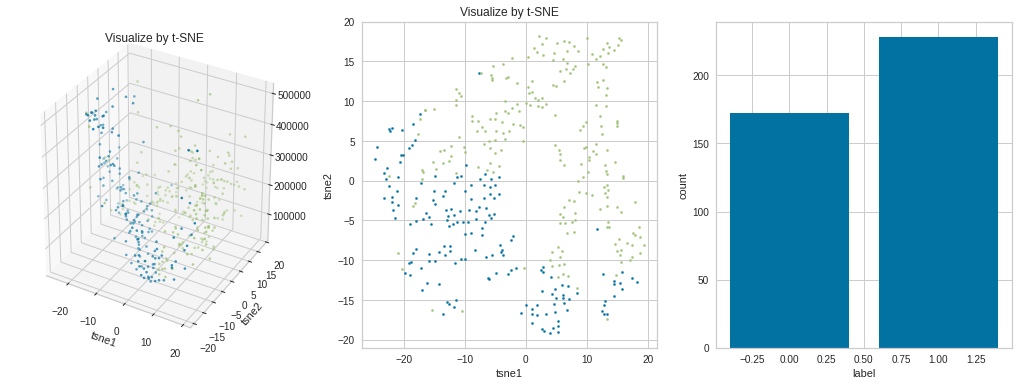




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms']
n_cluster:  2
Count labels:  2
Silhouette score:  0.4789139501196381


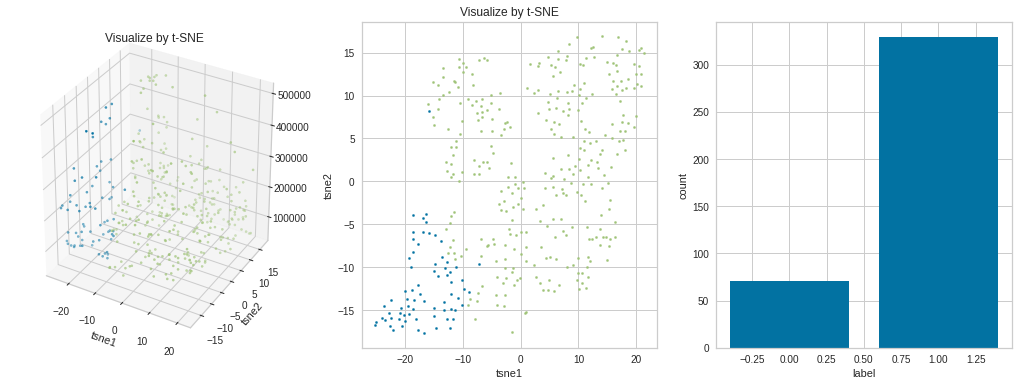




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  RobustScaler
Feature list:  ['median_income', 'total_rooms', 'housing_median_age']
n_cluster:  2
Count labels:  2
Silhouette score:  0.27524214542719133


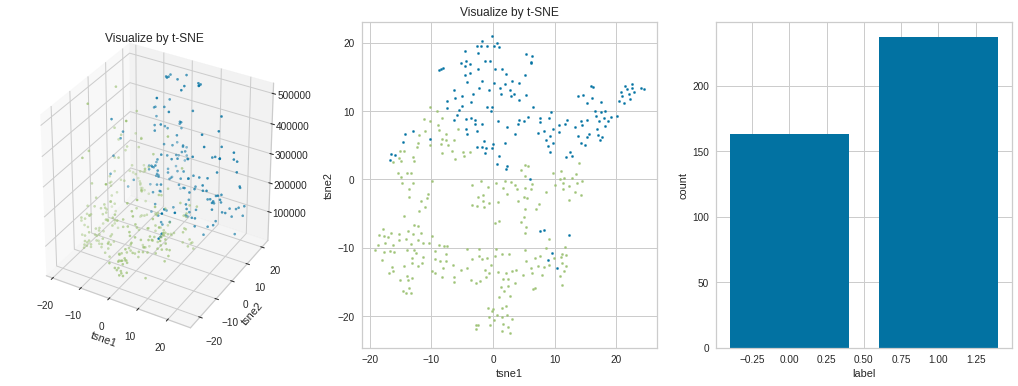




Model:  CLARANS
Encoder:  OneHotEncoder
Scaler:  RobustScaler
Feature list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
n_cluster:  4


KeyboardInterrupt: ignored

In [ ]:
model_list = ['CLARANS'] 
encoder_list = ['LabelEncoder', 'OneHotEncoder', 'TargetEncoder'] 
scaler_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler'] 
n_clusters = [2, 4, 6, 8, 10] 

feature_combinations = [ ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity'], 
['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms'],
['median_income', 'total_rooms', 'housing_median_age']] 
hyper_parameter_dict = {
    'KMeans' : {'random_state' : [1, 2]},
    'DBSCAN' : {'eps':[0.5, 0.7, 0.9, 1.1, 1.3], 'min_samples':[3, 4, 6]},
    'EM':{'n_components':[2, 4, 6, 8, 10],'random_state':[1,2]},
    'CLARANS' : {'numlocal' : [6, 8, 10], 'maxneighbor' : [4, 6]}
}

AutoML(data, model_list, encoder_list, scaler_list, n_clusters, feature_combinations, hyper_parameter_dict, silhouette_score)